<a href="https://colab.research.google.com/github/APerson101/waymo/blob/main/dreamgaussian_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install waymo-open-dataset-tf-2-12-0==1.6.7


In [103]:
filepath='/content/drive/MyDrive/uncompressed_tf_example_testing_testing_tfexample.tfrecord-00001-of-00150'

import math
import os
import uuid
import time

from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import numpy as np
from IPython.display import HTML
import itertools
import tensorflow as tf

from google.protobuf import text_format
from waymo_open_dataset.metrics.ops import py_metrics_ops
from waymo_open_dataset.metrics.python import config_util_py as config_util
from waymo_open_dataset.protos import motion_metrics_pb2

# If you use a custom conversion from Scenario to tf.Example, set the correct
# number of map samples here.
num_map_samples = 30000

# Example field definition
roadgraph_features = {
    'roadgraph_samples/dir': tf.io.FixedLenFeature(
        [num_map_samples, 3], tf.float32, default_value=None
    ),
    'roadgraph_samples/id': tf.io.FixedLenFeature(
        [num_map_samples, 1], tf.int64, default_value=None
    ),
    'roadgraph_samples/type': tf.io.FixedLenFeature(
        [num_map_samples, 1], tf.int64, default_value=None
    ),
    'roadgraph_samples/valid': tf.io.FixedLenFeature(
        [num_map_samples, 1], tf.int64, default_value=None
    ),
    'roadgraph_samples/xyz': tf.io.FixedLenFeature(
        [num_map_samples, 3], tf.float32, default_value=None
    ),
}
# Features of other agents.
state_features = {
    'state/id':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/type':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/is_sdc':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/tracks_to_predict':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/current/bbox_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/height':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/length':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/timestamp_micros':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/valid':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/vel_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/width':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/z':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/future/bbox_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/height':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/length':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/timestamp_micros':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/valid':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/vel_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/width':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/z':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/past/bbox_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/height':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/length':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/timestamp_micros':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/valid':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/vel_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/width':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/z':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
}

traffic_light_features = {
    'traffic_light_state/current/state':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/valid':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/x':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/y':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/z':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/past/state':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/valid':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/x':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/y':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/z':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
}

features_description = {}
features_description.update(roadgraph_features)
features_description.update(state_features)
features_description.update(traffic_light_features)


dataset = tf.data.TFRecordDataset(filepath, compression_type='')
data = next(dataset.as_numpy_iterator())
parsed = tf.io.parse_single_example(data, features_description)

In [109]:
def create_figure_and_axes(size_pixels):
  """Initializes a unique figure and axes for plotting."""
  fig, ax = plt.subplots(1, 1, num=uuid.uuid4())

  # Sets output image to pixel resolution.
  dpi = 100
  size_inches = size_pixels / dpi
  fig.set_size_inches([size_inches, size_inches])
  fig.set_dpi(dpi)
  fig.set_facecolor('white')
  ax.set_facecolor('white')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(axis='y', colors='black')
  fig.set_tight_layout(True)
  ax.grid(False)
  return fig, ax


def fig_canvas_image(fig):
  """Returns a [H, W, 3] uint8 np.array image from fig.canvas.tostring_rgb()."""
  # Just enough margin in the figure to display xticks and yticks.
  fig.subplots_adjust(
      left=0.08, bottom=0.08, right=0.98, top=0.98, wspace=0.0, hspace=0.0)
  fig.canvas.draw()
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  return data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


def get_colormap(num_agents):
  """Compute a color map array of shape [num_agents, 4]."""
  colors = cm.get_cmap('jet', num_agents)
  colors = colors(range(num_agents))
  np.random.shuffle(colors)
  return colors


def get_viewport(all_states, all_states_mask):
  """Gets the region containing the data.

  Args:
    all_states: states of agents as an array of shape [num_agents, num_steps,
      2].
    all_states_mask: binary mask of shape [num_agents, num_steps] for
      `all_states`.

  Returns:
    center_y: float. y coordinate for center of data.
    center_x: float. x coordinate for center of data.
    width: float. Width of data.
  """
  valid_states = all_states[all_states_mask]
  all_y = valid_states[..., 1]
  all_x = valid_states[..., 0]

  center_y = (np.max(all_y) + np.min(all_y)) / 2
  center_x = (np.max(all_x) + np.min(all_x)) / 2

  range_y = np.ptp(all_y)
  range_x = np.ptp(all_x)

  width = max(range_y, range_x)

  return center_y, center_x, width


def visualize_one_step(states,
                       mask,
                       roadgraph,
                       title,
                       center_y,
                       center_x,
                       width,
                       color_map,
                       size_pixels=1000):
  """Generate visualization for a single step."""

  # Create figure and axes.
  fig, ax = create_figure_and_axes(size_pixels=size_pixels)

  # Plot roadgraph.
  rg_pts = roadgraph[:, :2].T
  ax.plot(rg_pts[0, :], rg_pts[1, :], 'k.', alpha=1, ms=2)

  masked_x = states[:, 0][mask]
  masked_y = states[:, 1][mask]
  colors = color_map[mask]

  # Plot agent current position.
  ax.scatter(
      masked_x,
      masked_y,
      marker='o',
      linewidths=3,
      color=colors,
  )

  # Title.
  ax.set_title(title)

  # Set axes.  Should be at least 10m on a side and cover 160% of agents.
  size = max(10, width * 1.0)
  ax.axis([
      -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
      size / 2 + center_y
  ])
  ax.set_aspect('equal')

  image = fig_canvas_image(fig)
  # plt.close(fig)
  plt.show(image)
  return image


def visualize_all_agents_smooth(
    decoded_example,
    size_pixels=1000,
):
  """Visualizes all agent predicted trajectories in a serie of images.

  Args:
    decoded_example: Dictionary containing agent info about all modeled agents.
    size_pixels: The size in pixels of the output image.

  Returns:
    T of [H, W, 3] uint8 np.arrays of the drawn matplotlib's figure canvas.
  """
  # [num_agents, num_past_steps, 2] float32.
  past_states = tf.stack(
      [decoded_example['state/past/x'], decoded_example['state/past/y']],
      -1).numpy()
  past_states_mask = decoded_example['state/past/valid'].numpy() > 0.0

  # [num_agents, 1, 2] float32.
  current_states = tf.stack(
      [decoded_example['state/current/x'], decoded_example['state/current/y']],
      -1).numpy()
  current_states_mask = decoded_example['state/current/valid'].numpy() > 0.0

  # [num_agents, num_future_steps, 2] float32.
  future_states = tf.stack(
      [decoded_example['state/future/x'], decoded_example['state/future/y']],
      -1).numpy()
  future_states_mask = decoded_example['state/future/valid'].numpy() > 0.0

  # [num_points, 3] float32.
  roadgraph_xyz = decoded_example['roadgraph_samples/xyz'].numpy()

  num_agents, num_past_steps, _ = past_states.shape
  num_future_steps = future_states.shape[1]

  color_map = get_colormap(num_agents)

  # [num_agens, num_past_steps + 1 + num_future_steps, depth] float32.
  all_states = np.concatenate([past_states, current_states, future_states], 1)

  # [num_agens, num_past_steps + 1 + num_future_steps] float32.
  all_states_mask = np.concatenate(
      [past_states_mask, current_states_mask, future_states_mask], 1)

  center_y, center_x, width = get_viewport(all_states, all_states_mask)

  images = []

  # Generate images from past time steps.
  for i, (s, m) in enumerate(
      zip(
          np.split(past_states, num_past_steps, 1),
          np.split(past_states_mask, num_past_steps, 1))):
    im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz,
                            'past: %d' % (num_past_steps - i), center_y,
                            center_x, width, color_map, size_pixels)
    images.append(im)

  # Generate one image for the current time step.
  s = current_states
  m = current_states_mask

  im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz, 'current', center_y,
                          center_x, width, color_map, size_pixels)
  images.append(im)

  # Generate images from future time steps.
  for i, (s, m) in enumerate(
      zip(
          np.split(future_states, num_future_steps, 1),
          np.split(future_states_mask, num_future_steps, 1))):
    im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz,
                            'future: %d' % (i + 1), center_y, center_x, width,
                            color_map, size_pixels)
    images.append(im)

  return images


# images = visualize_all_agents_smooth(parsed)

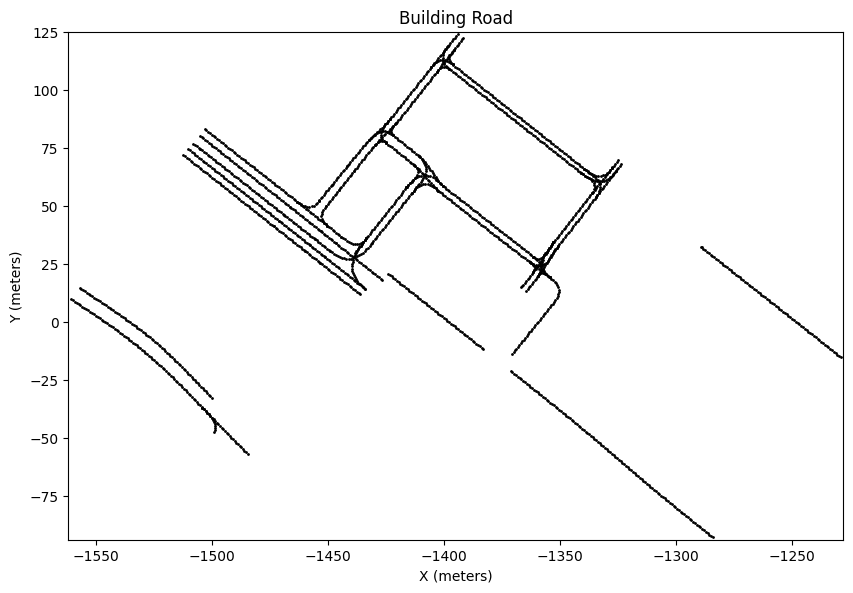

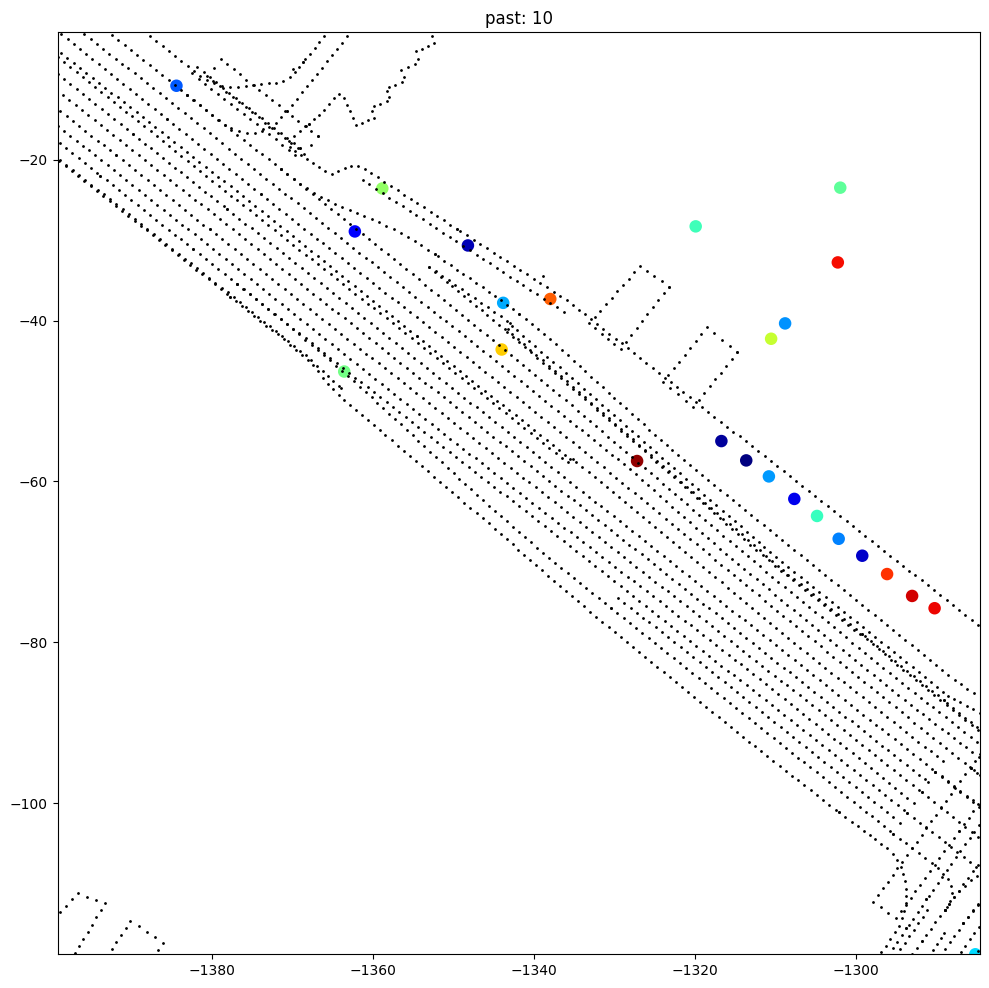

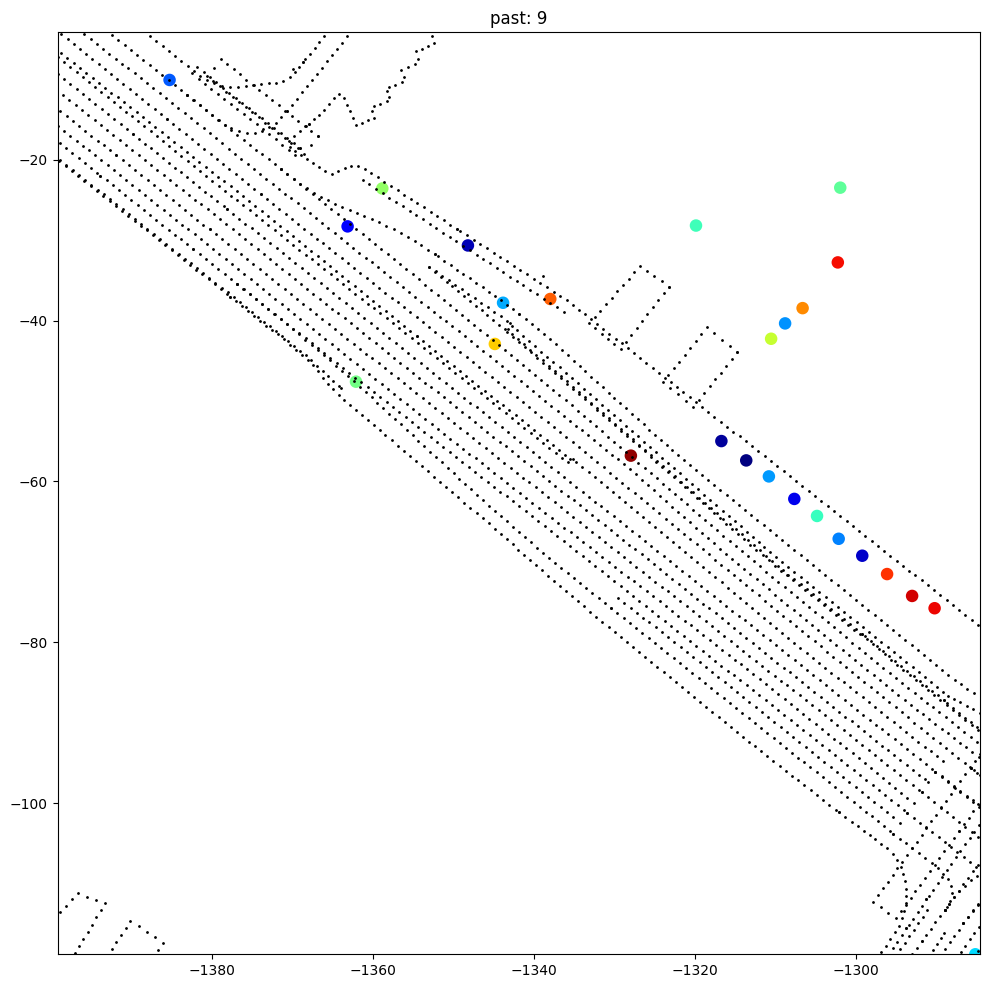

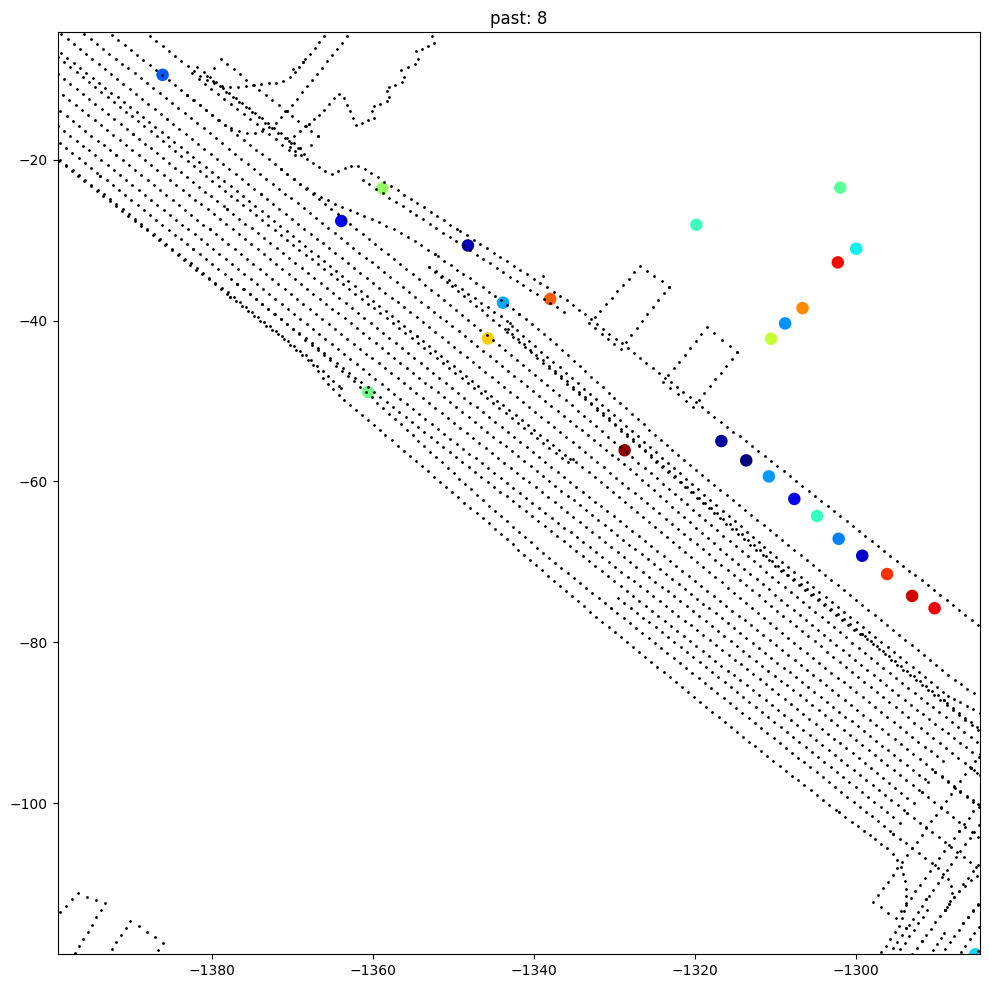

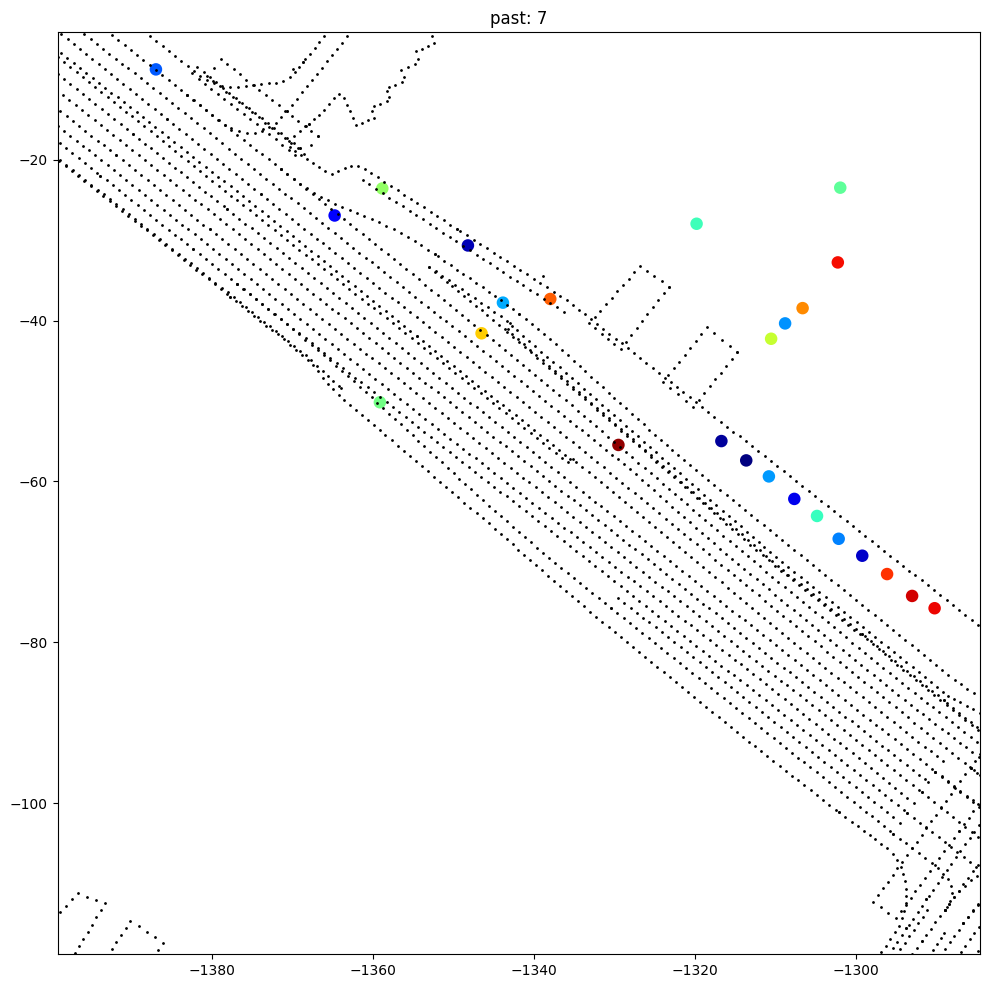

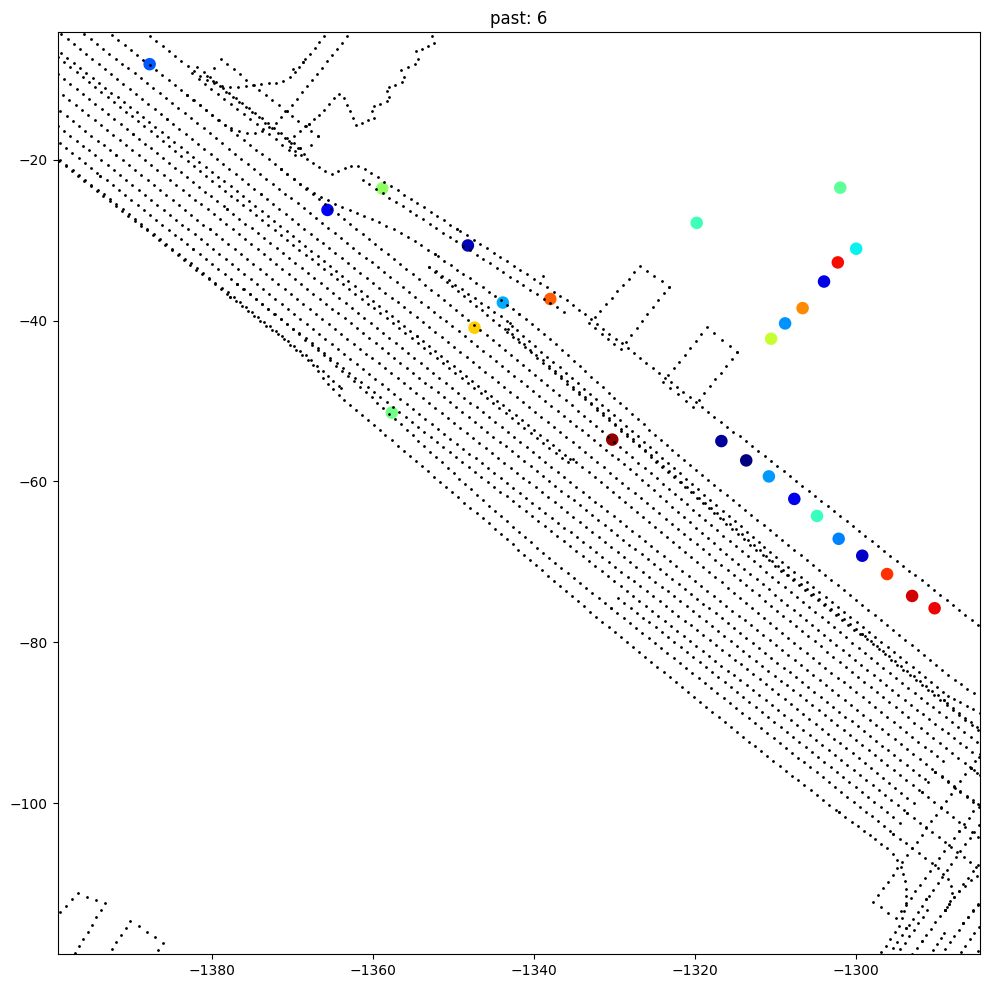

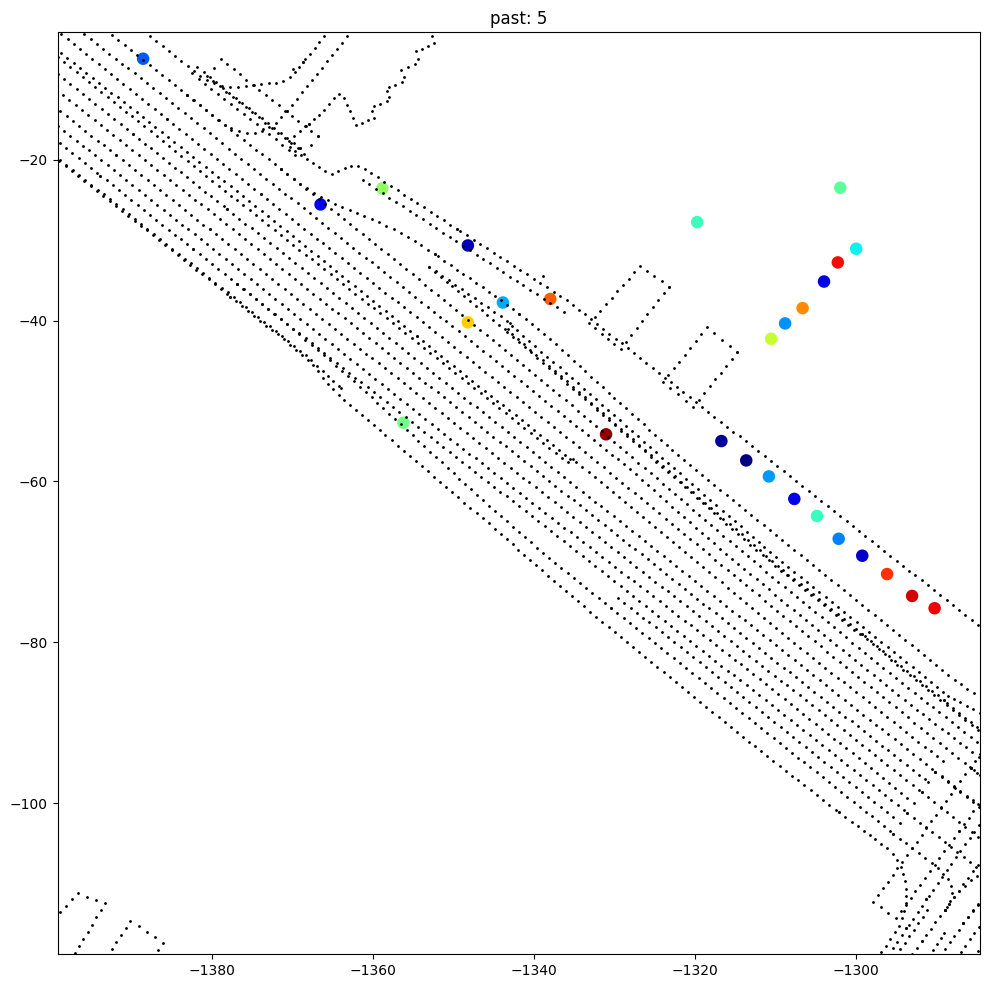

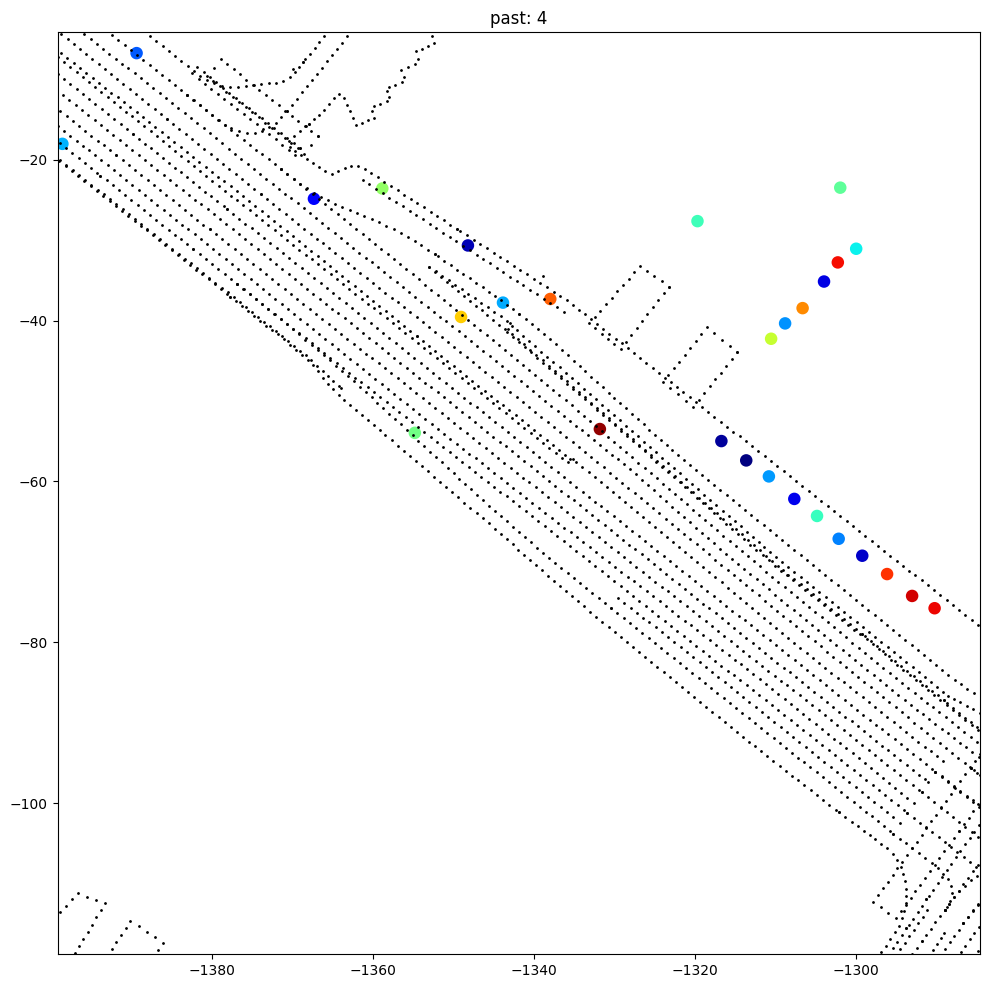

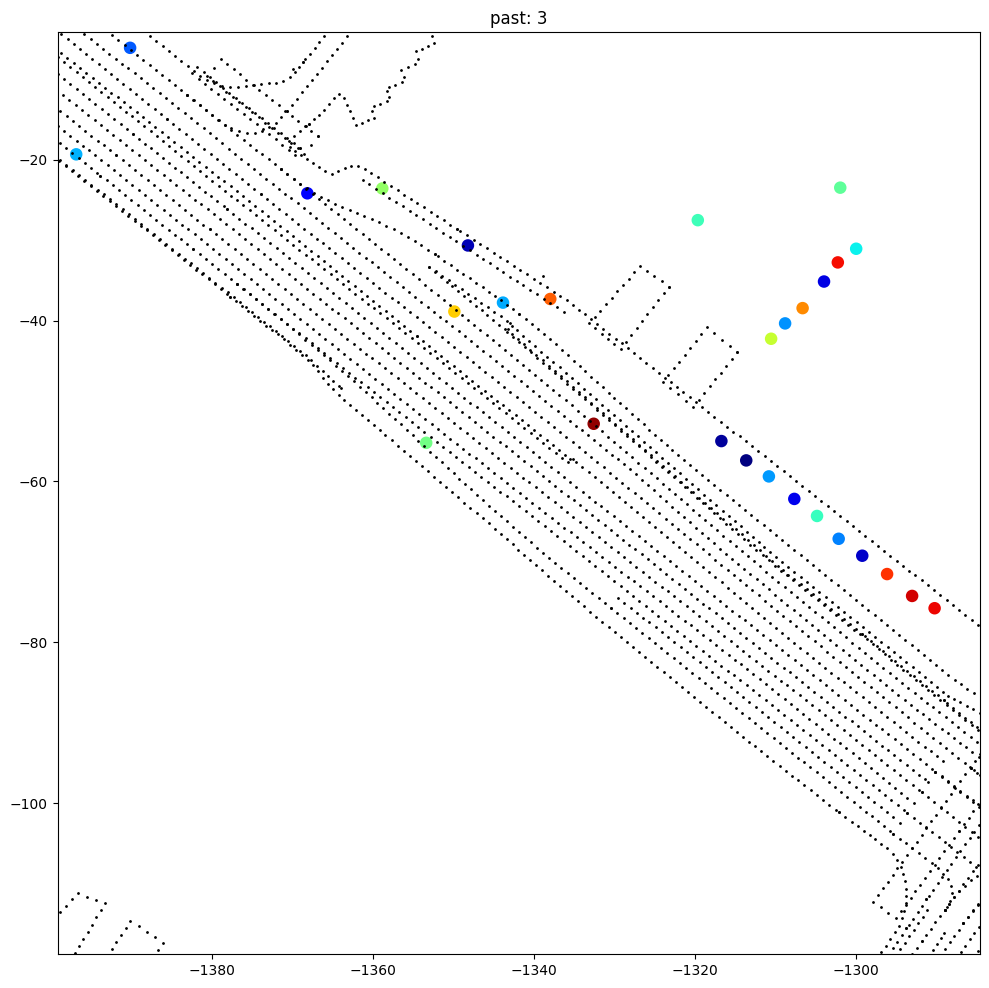

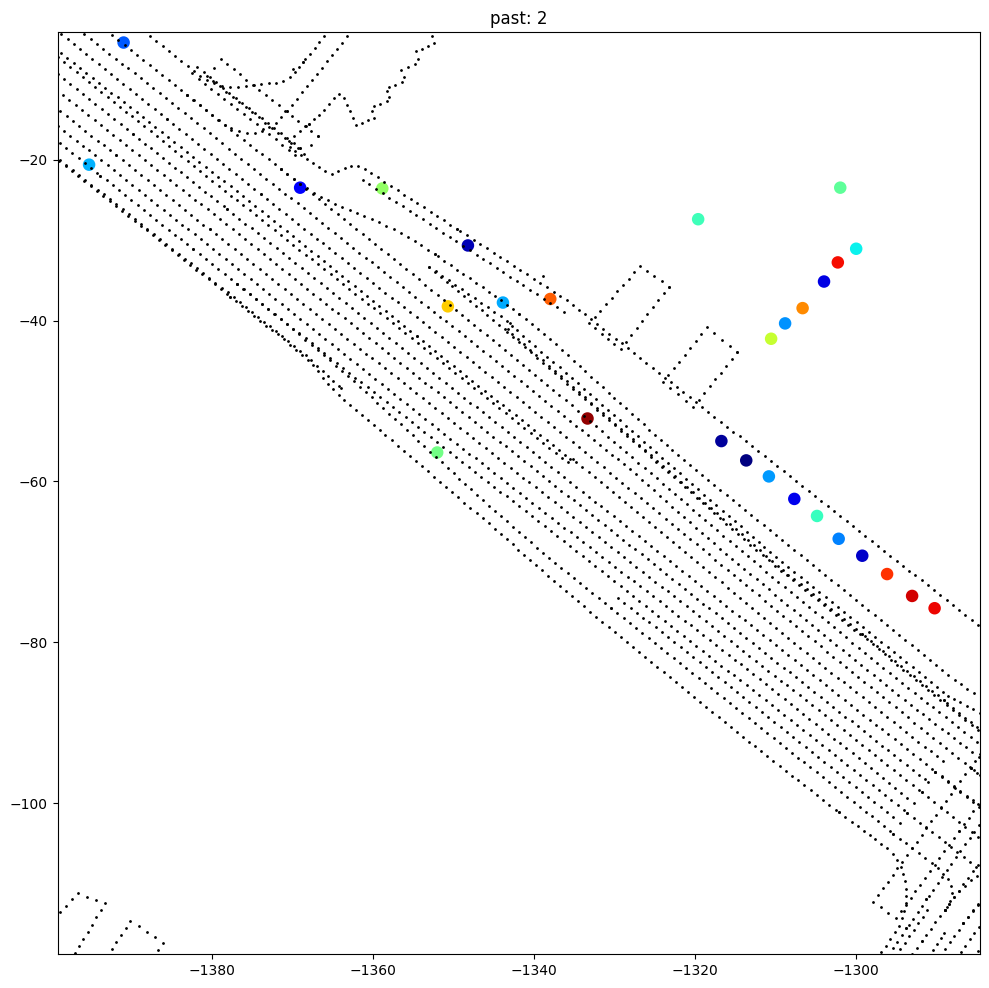

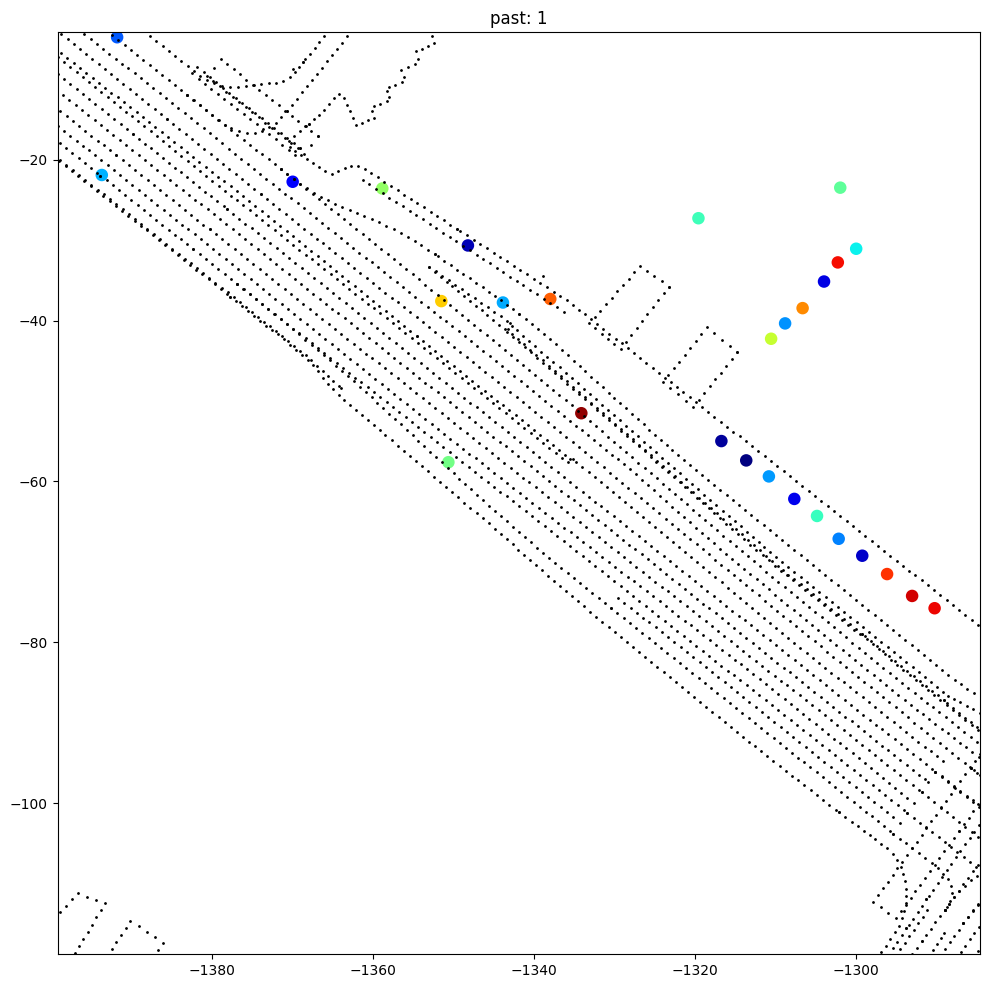

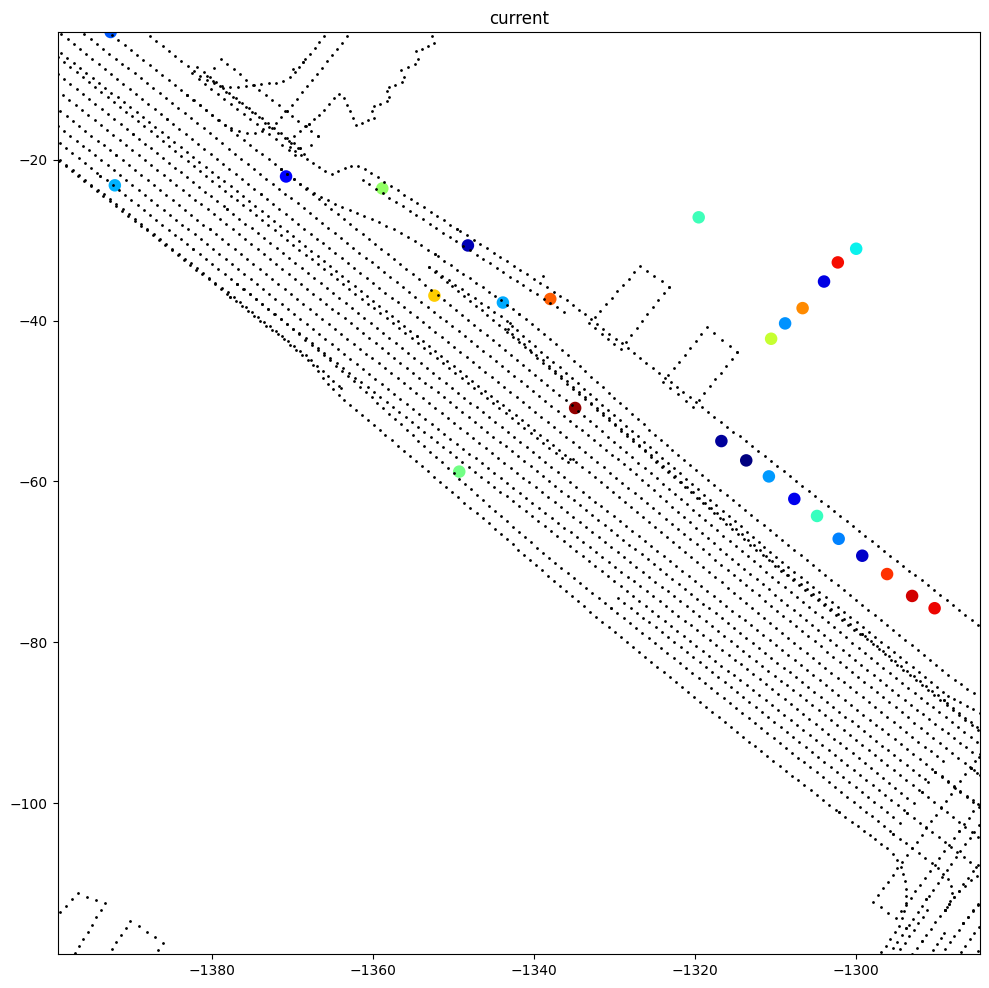

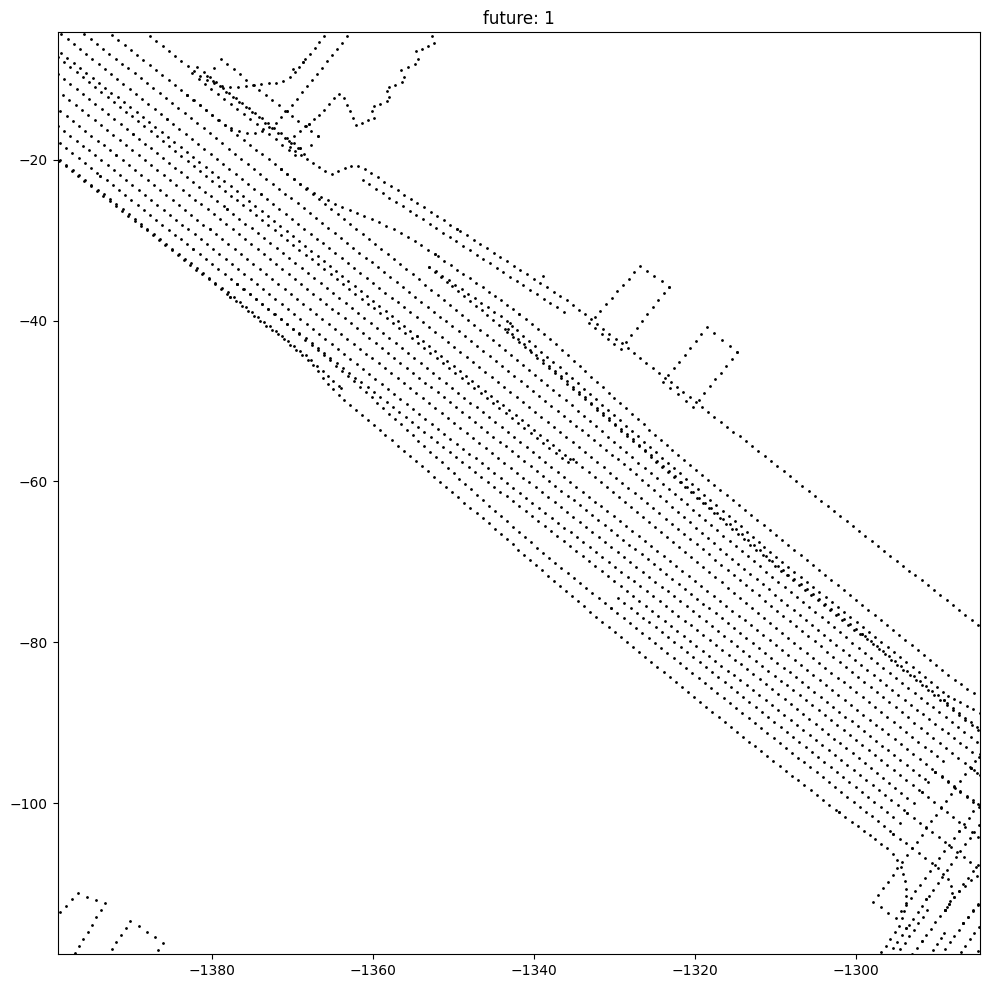

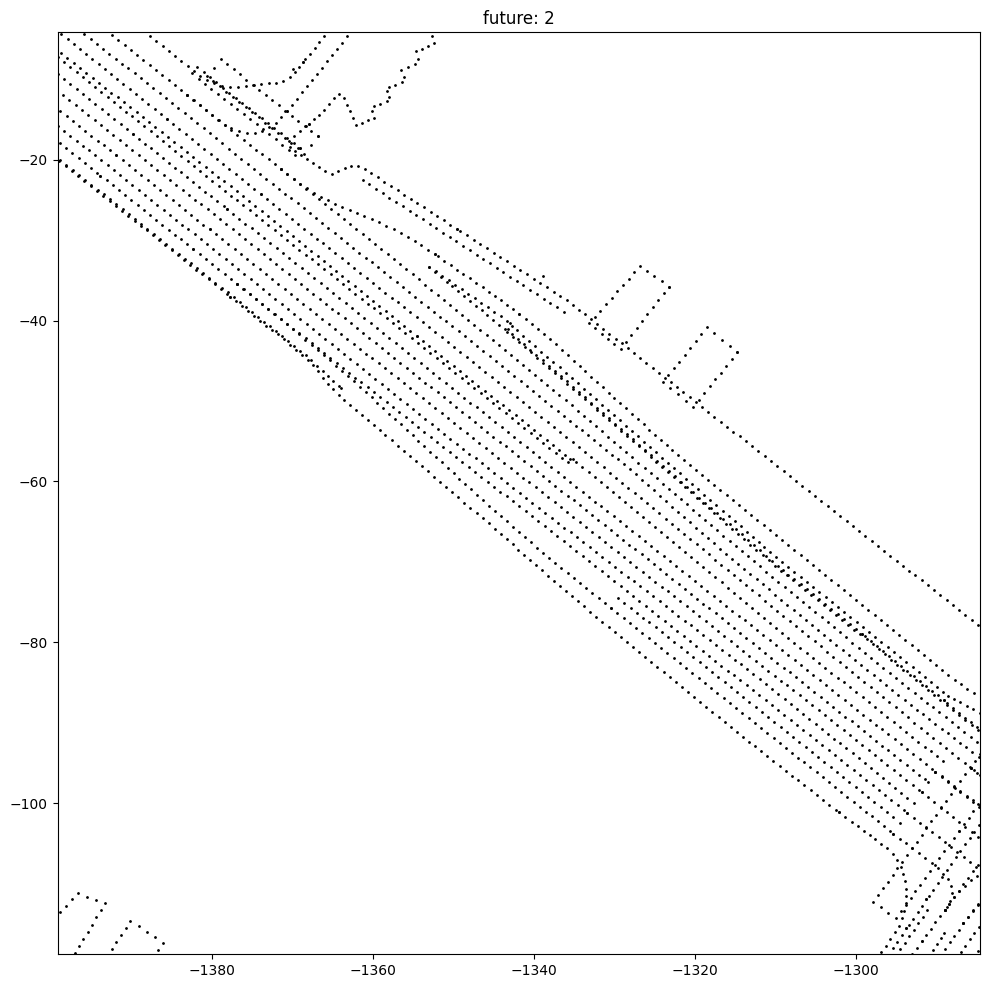

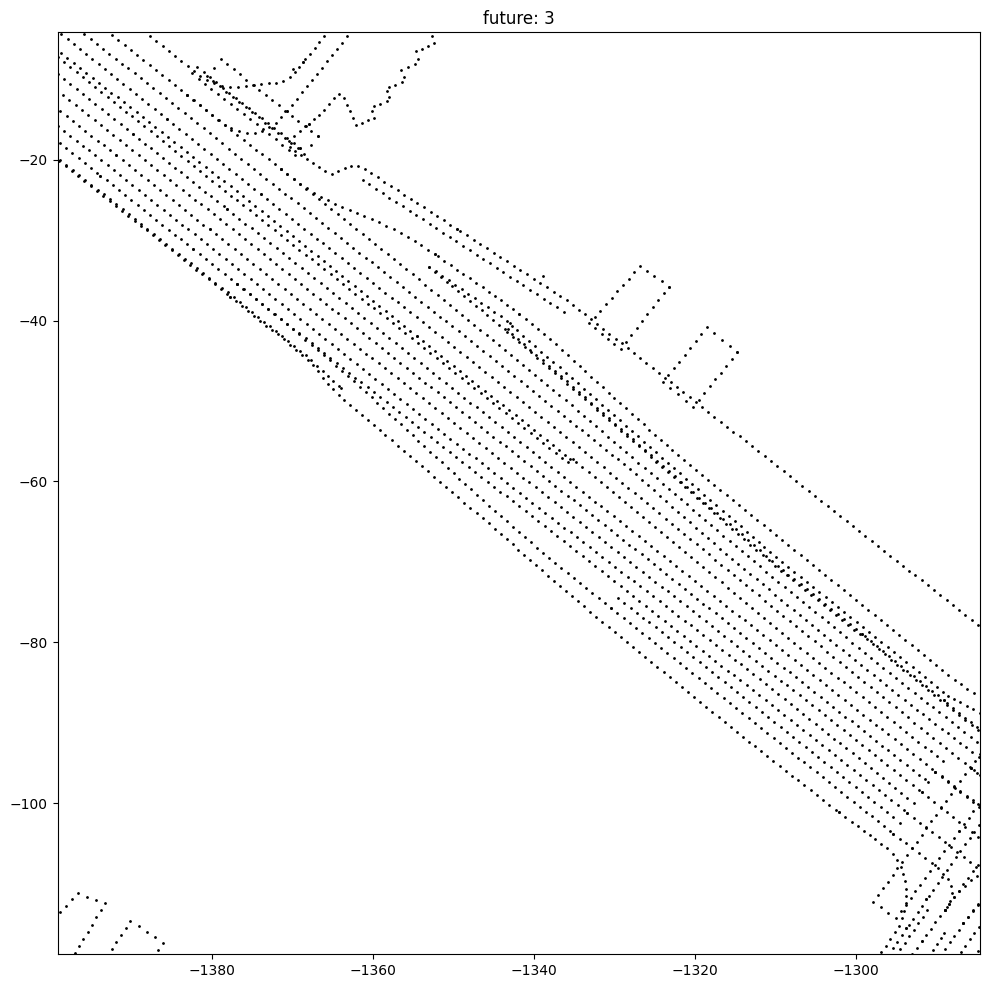

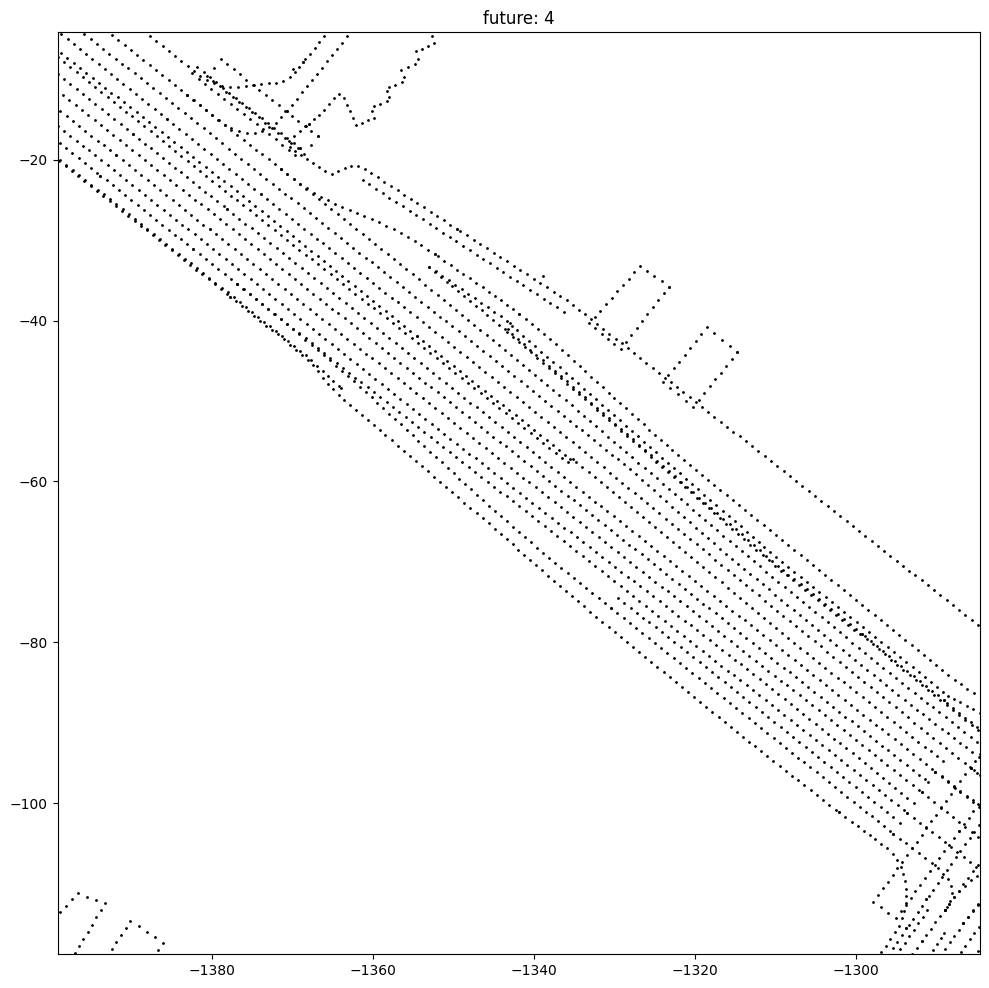

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7c4f58815c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))

KeyboardInterrupt: 


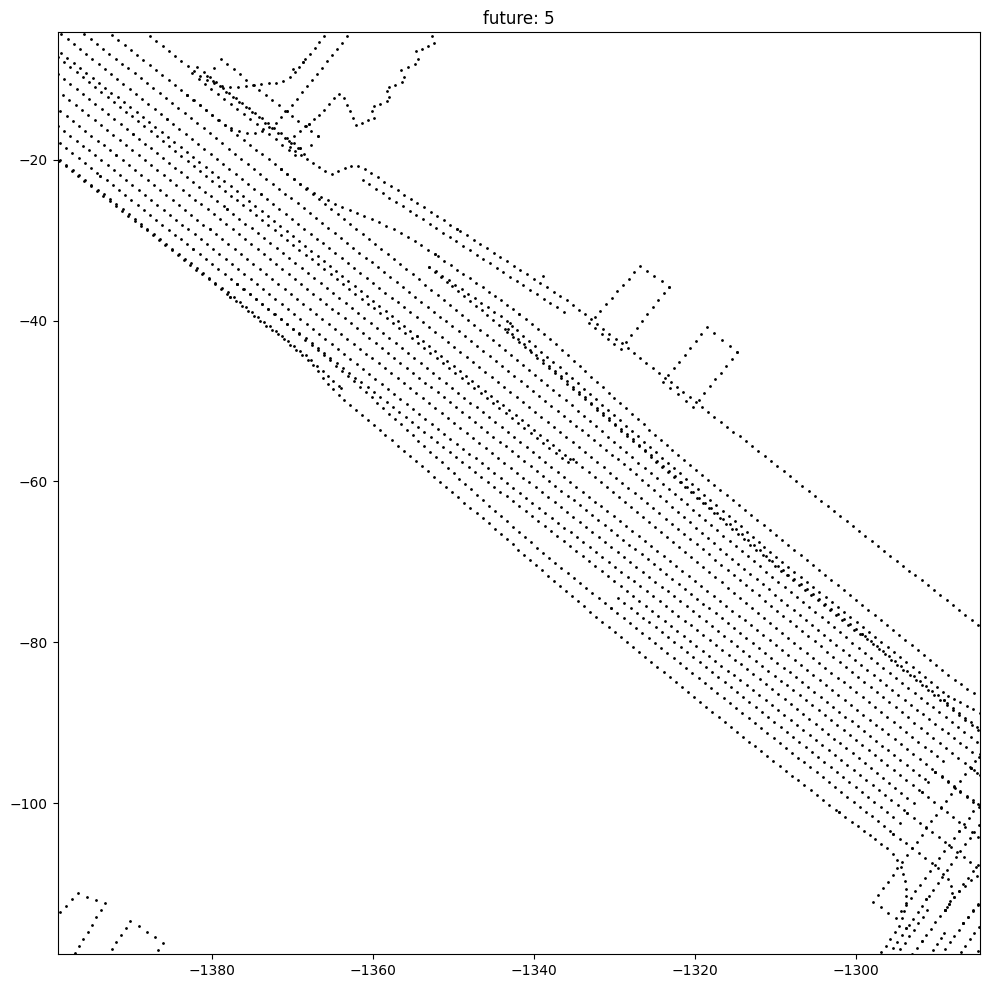

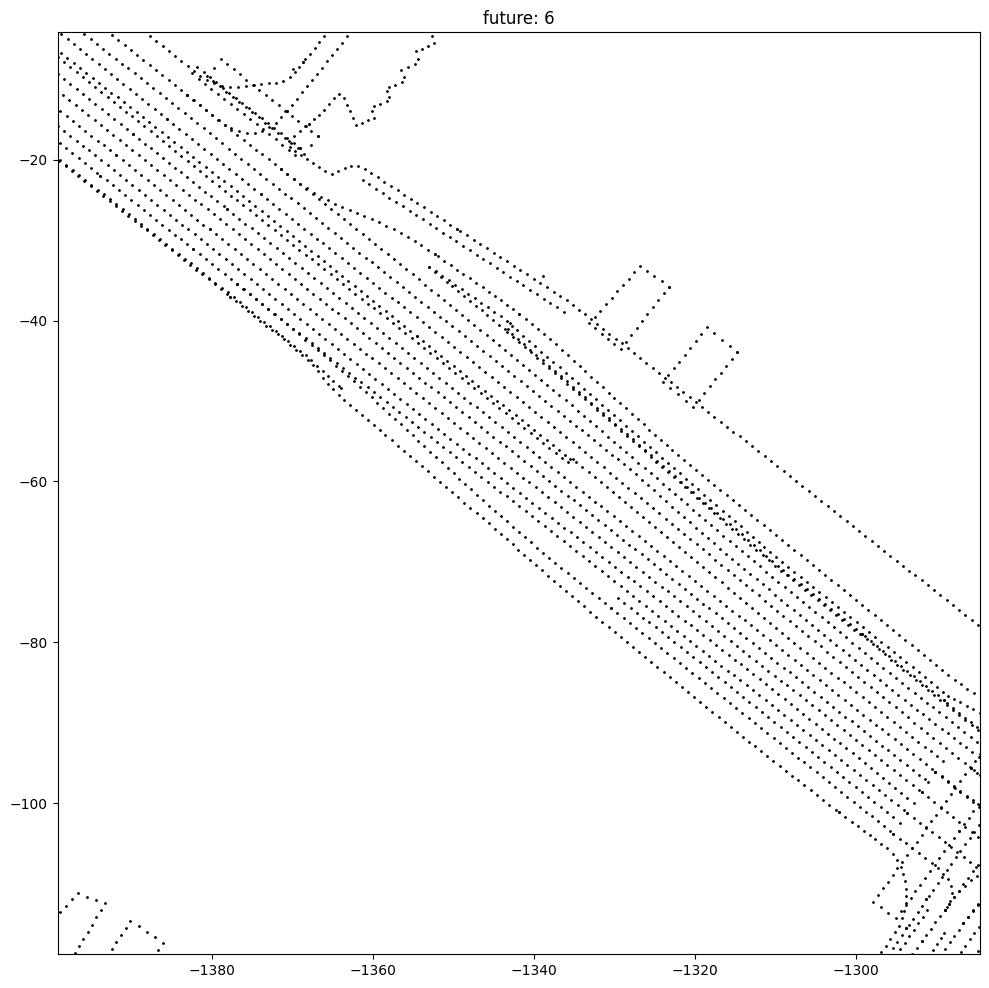

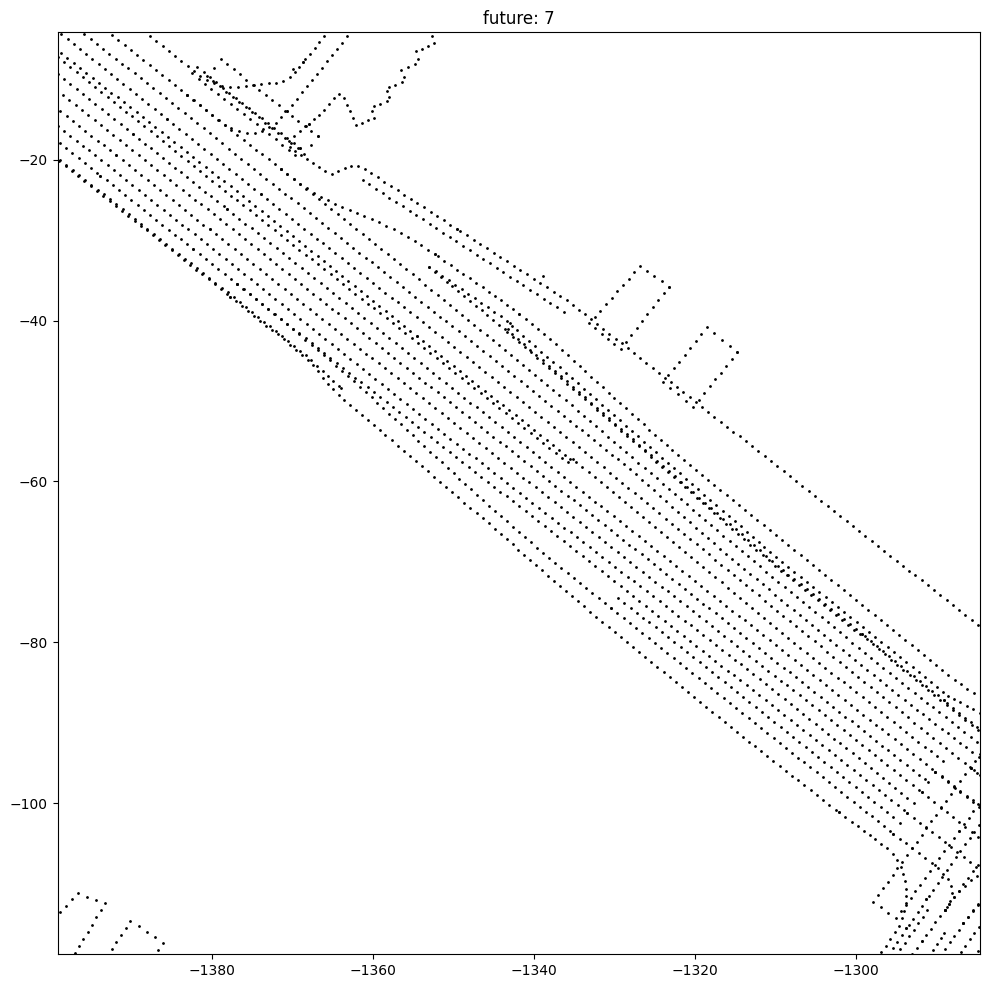

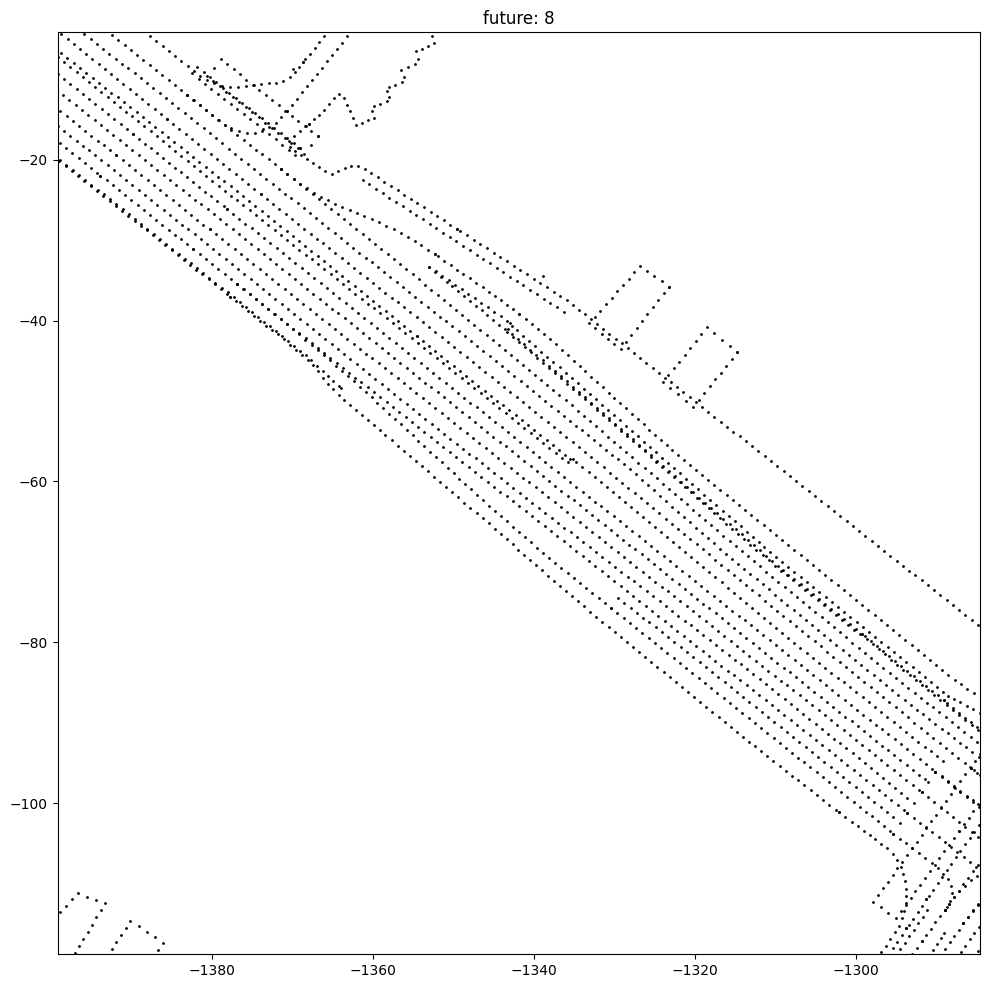

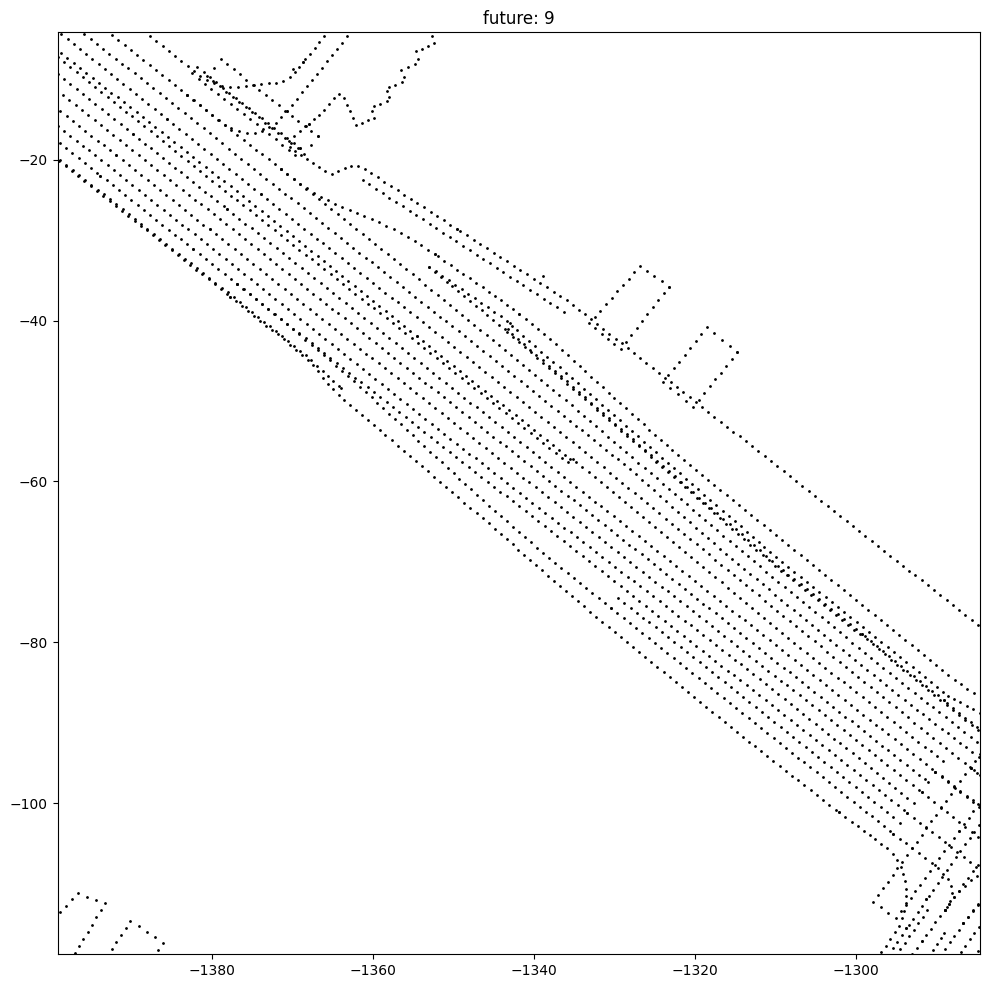

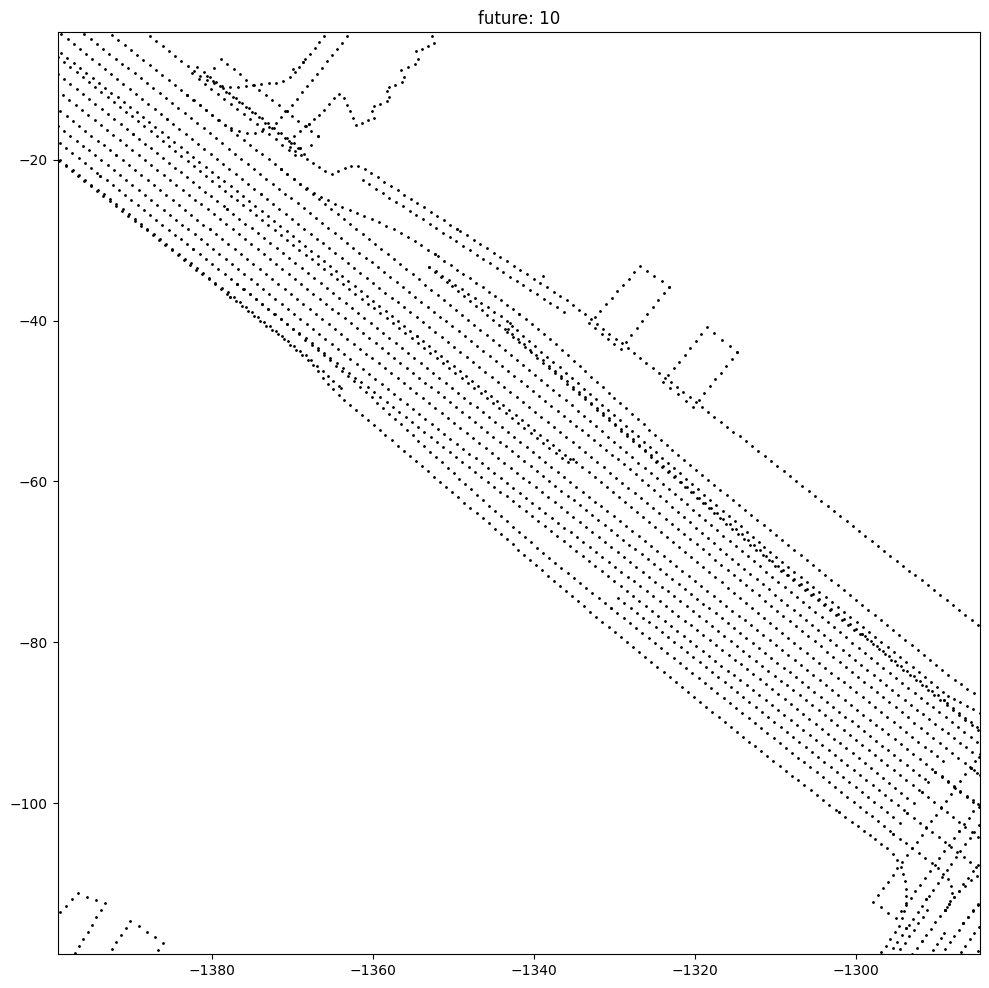

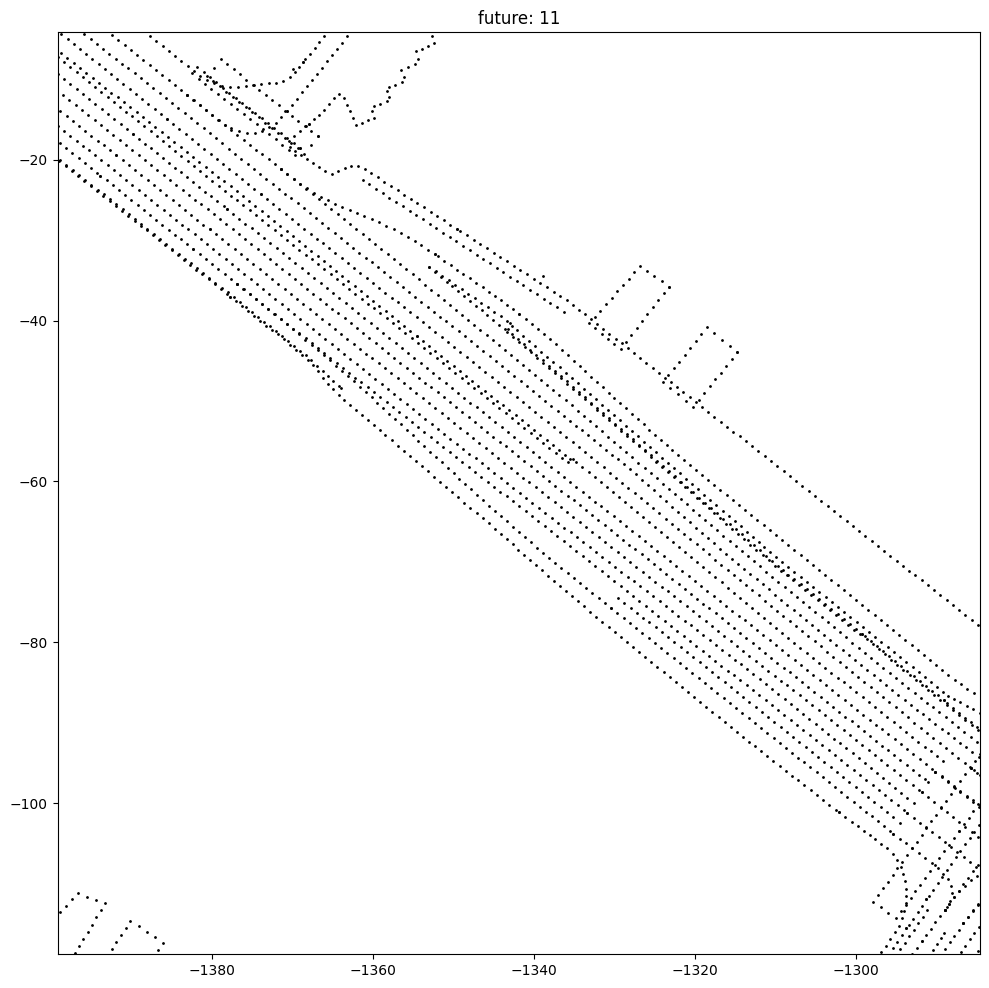

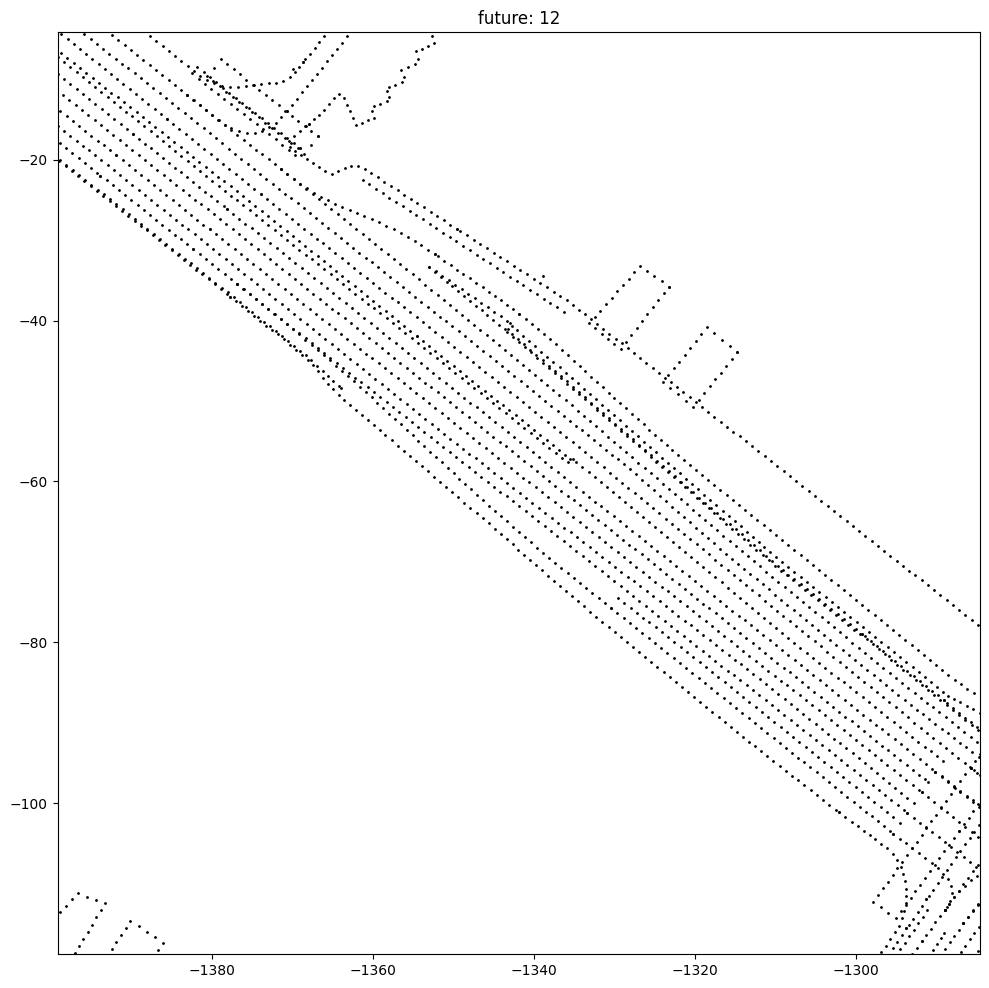

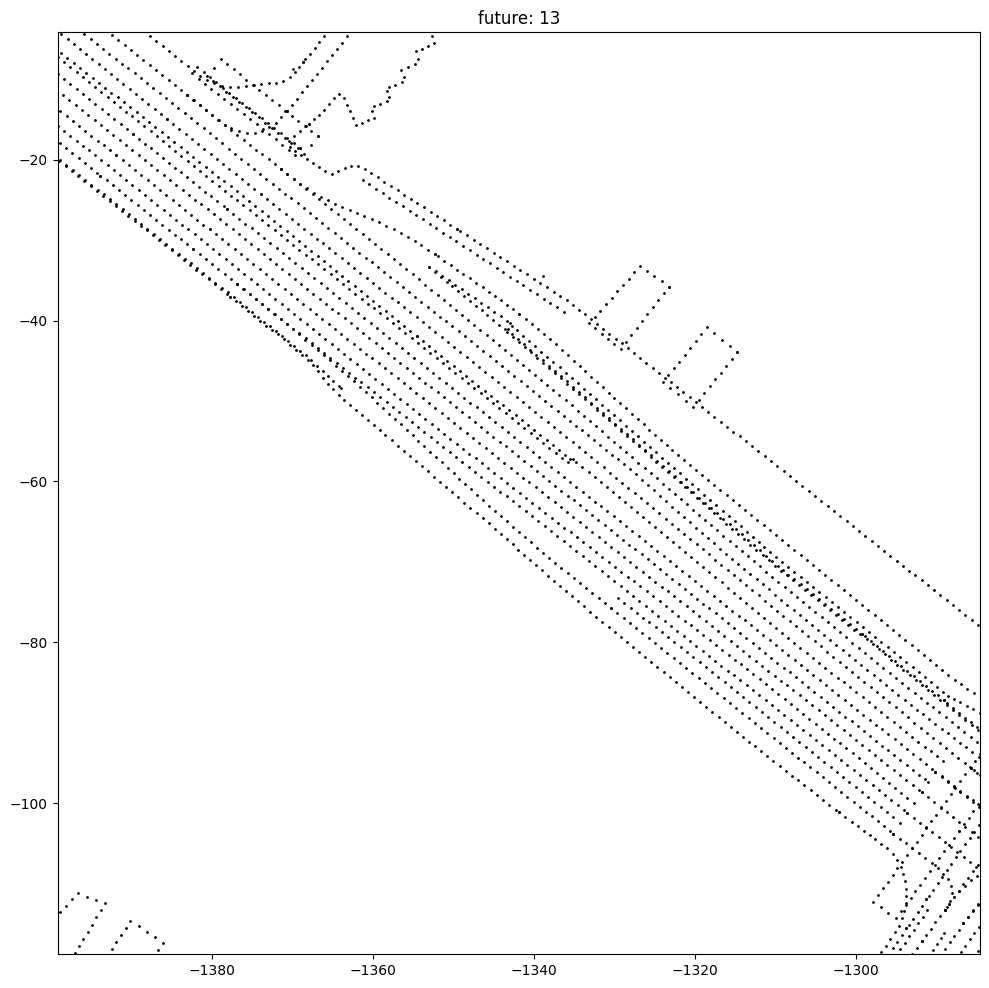

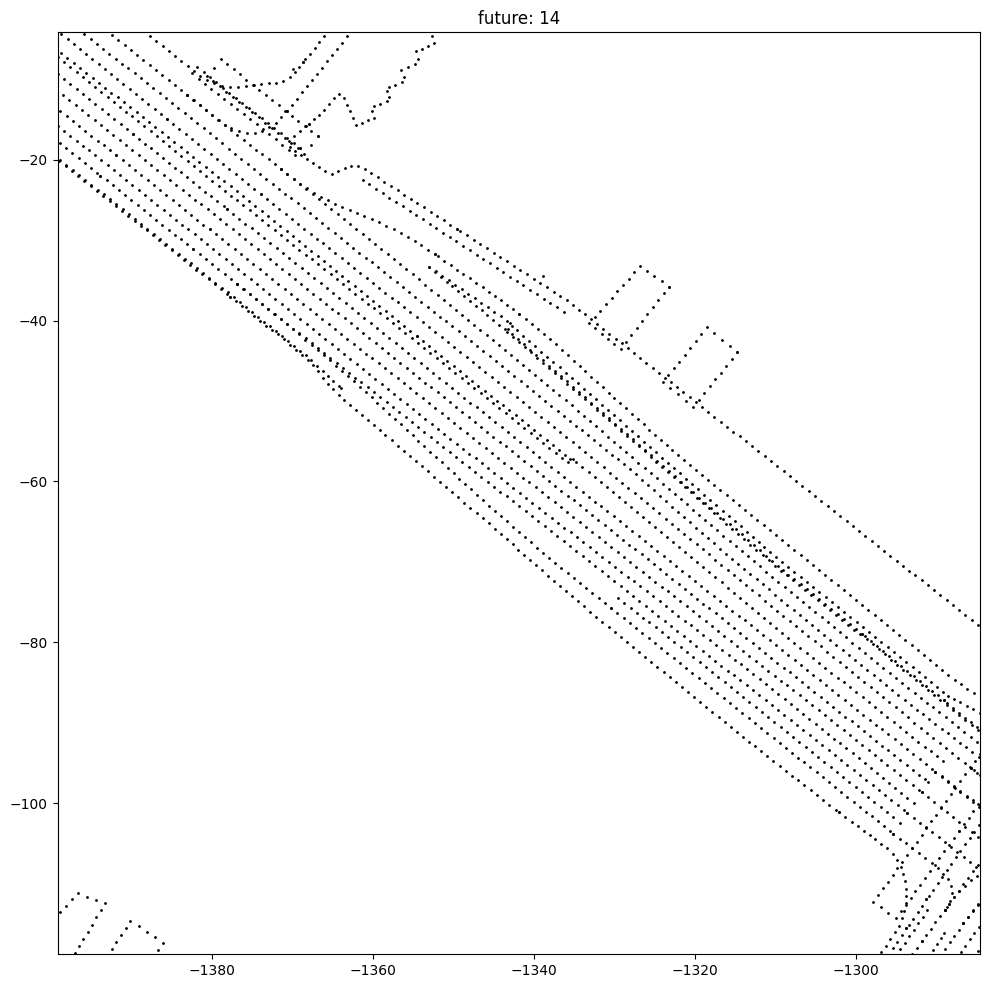

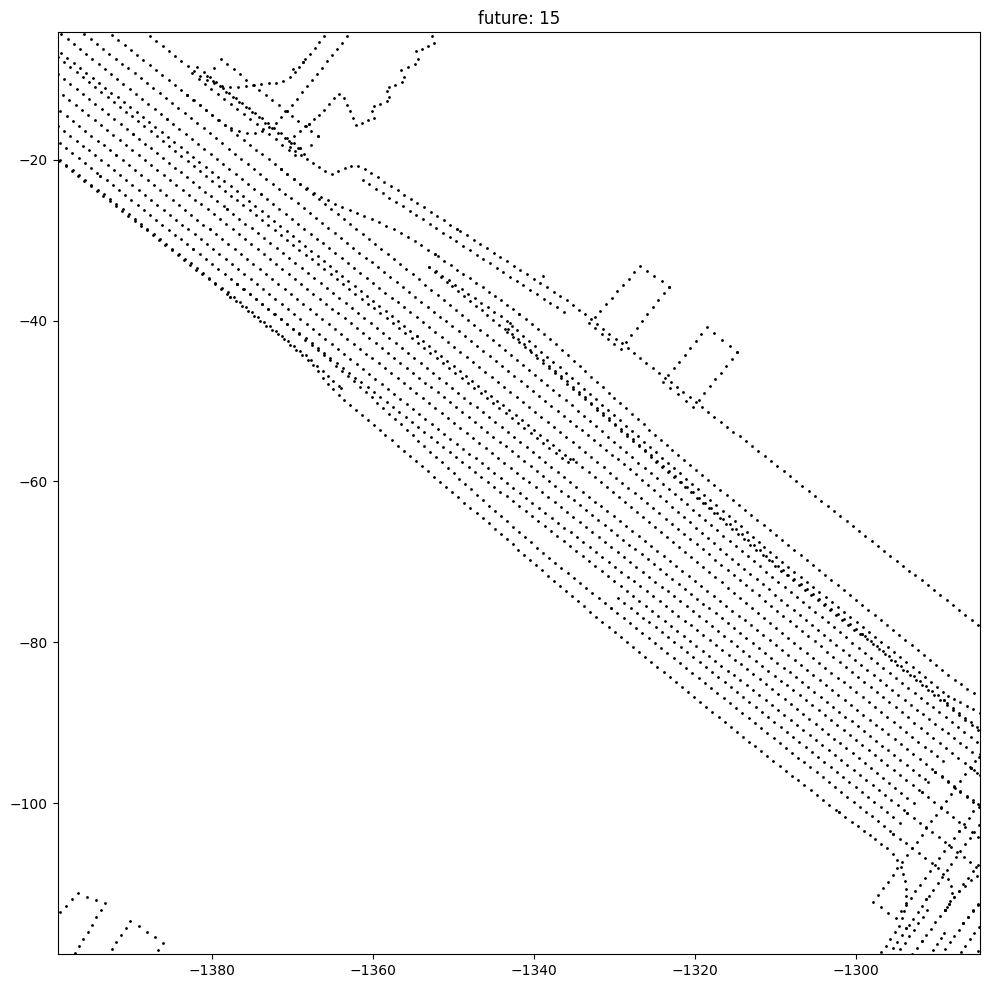

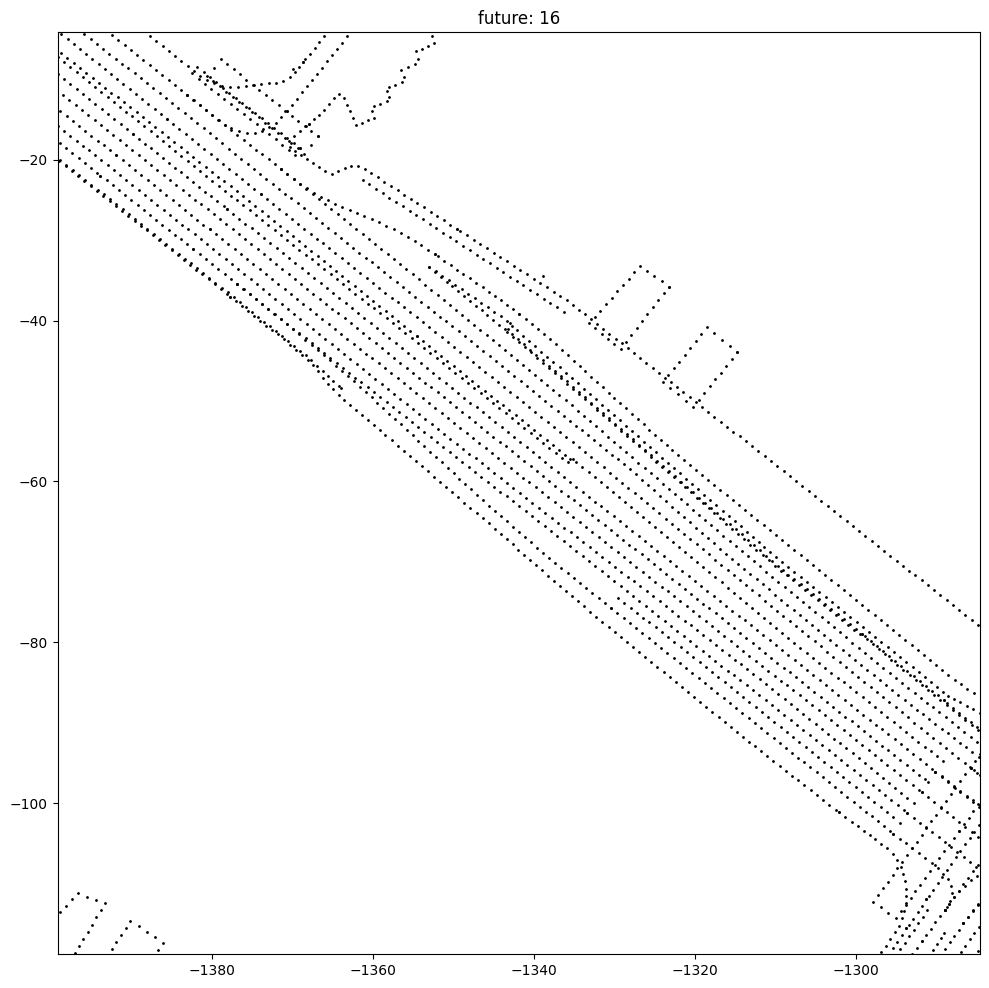

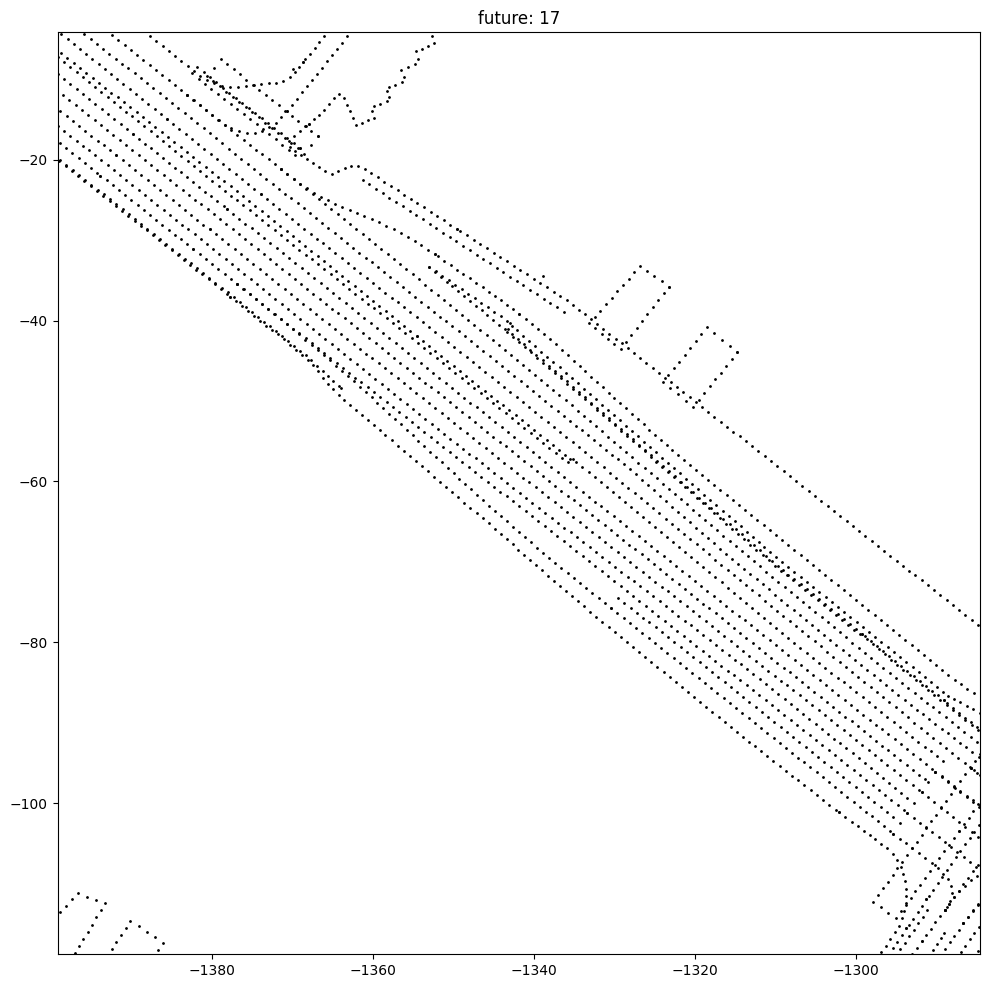

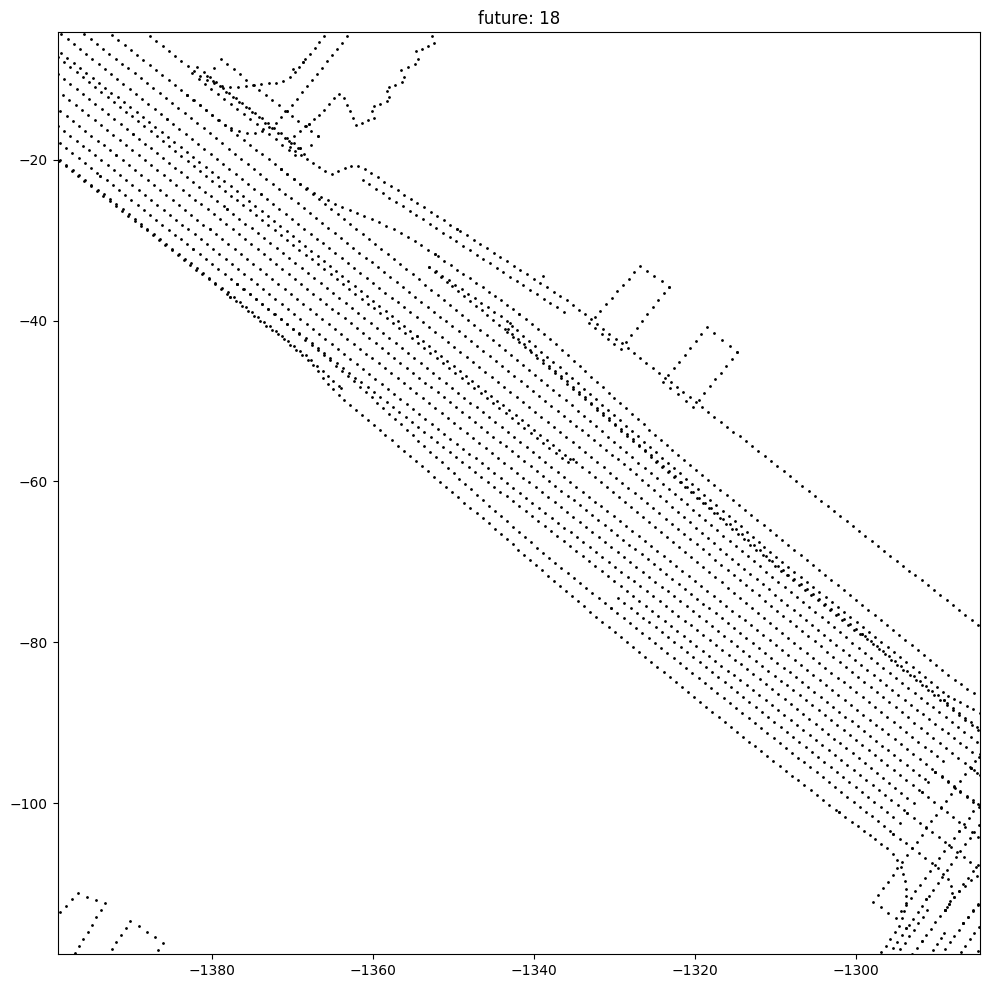

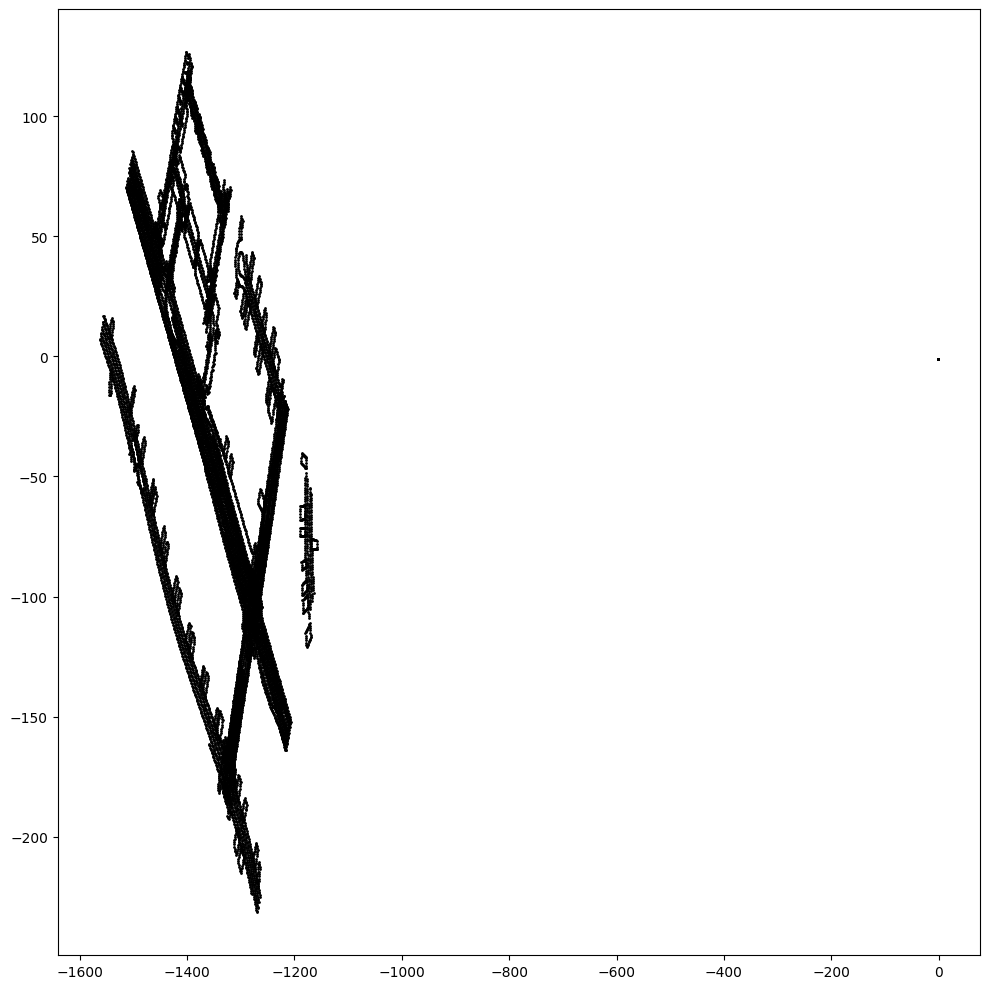

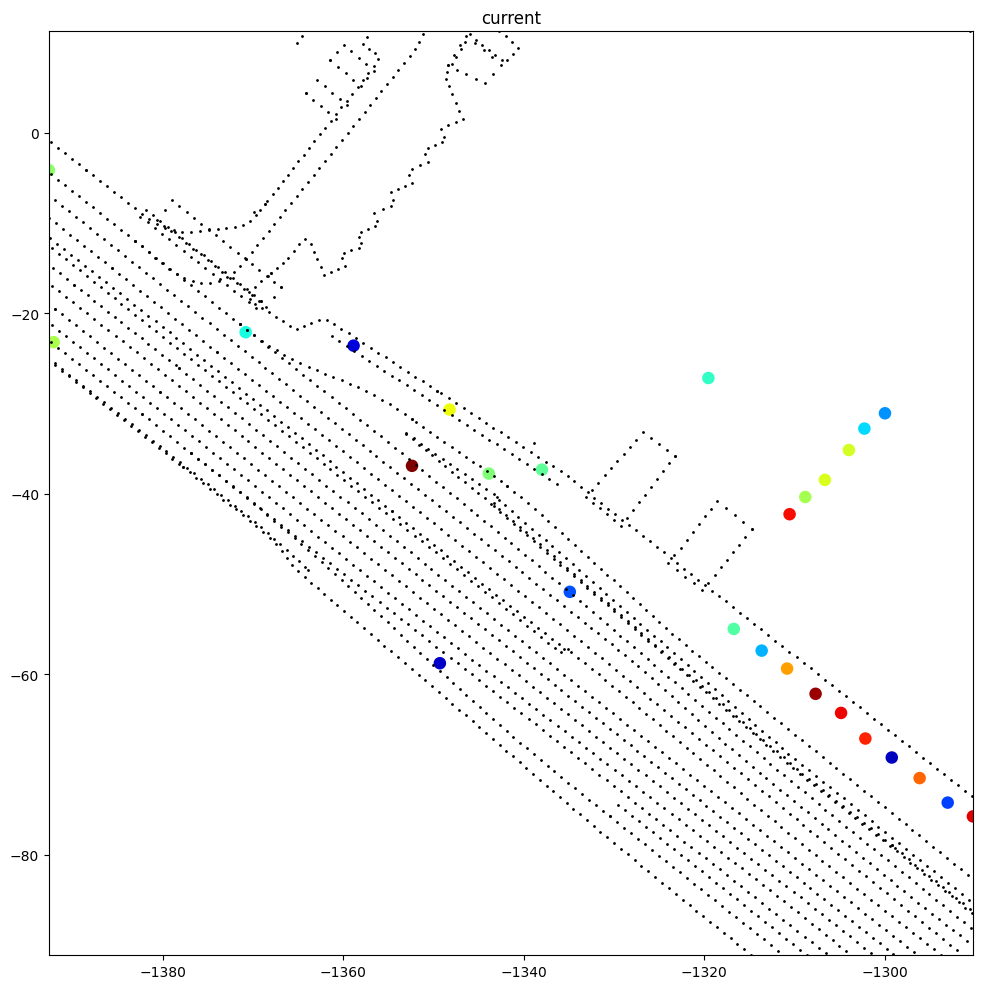

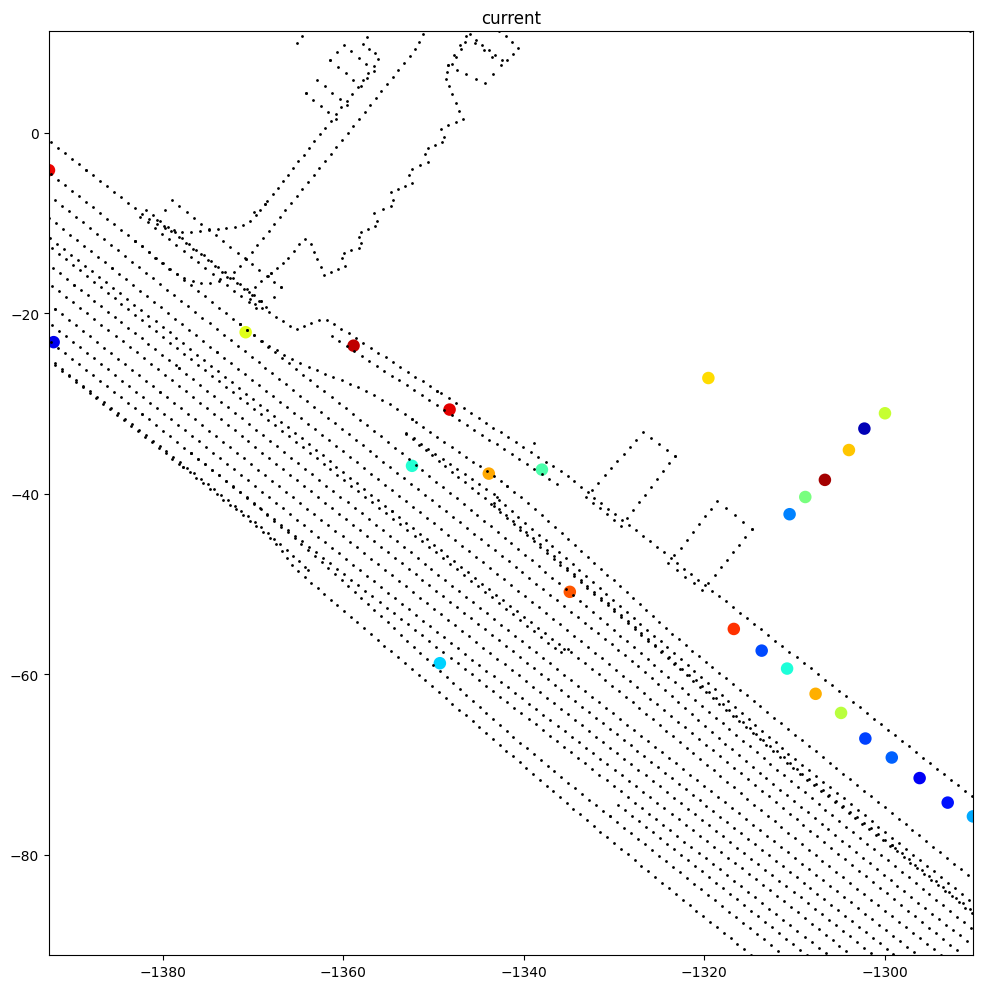

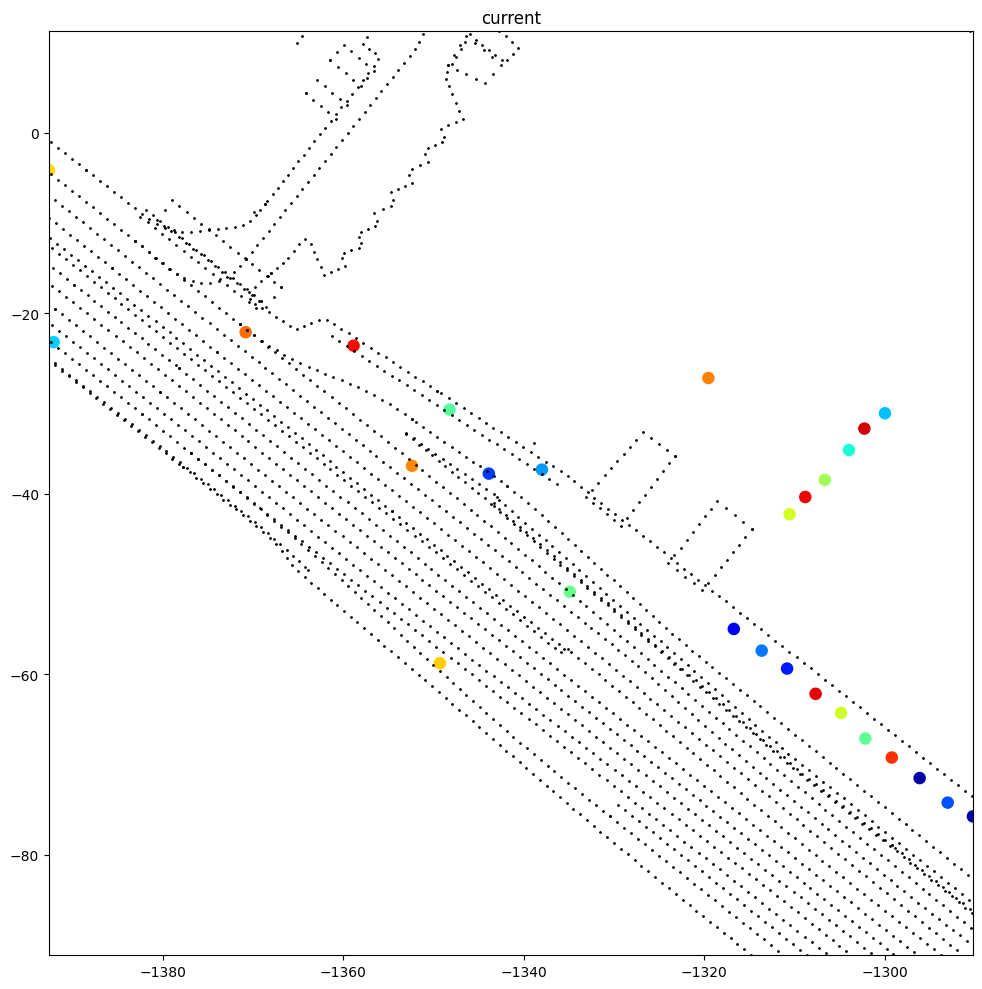

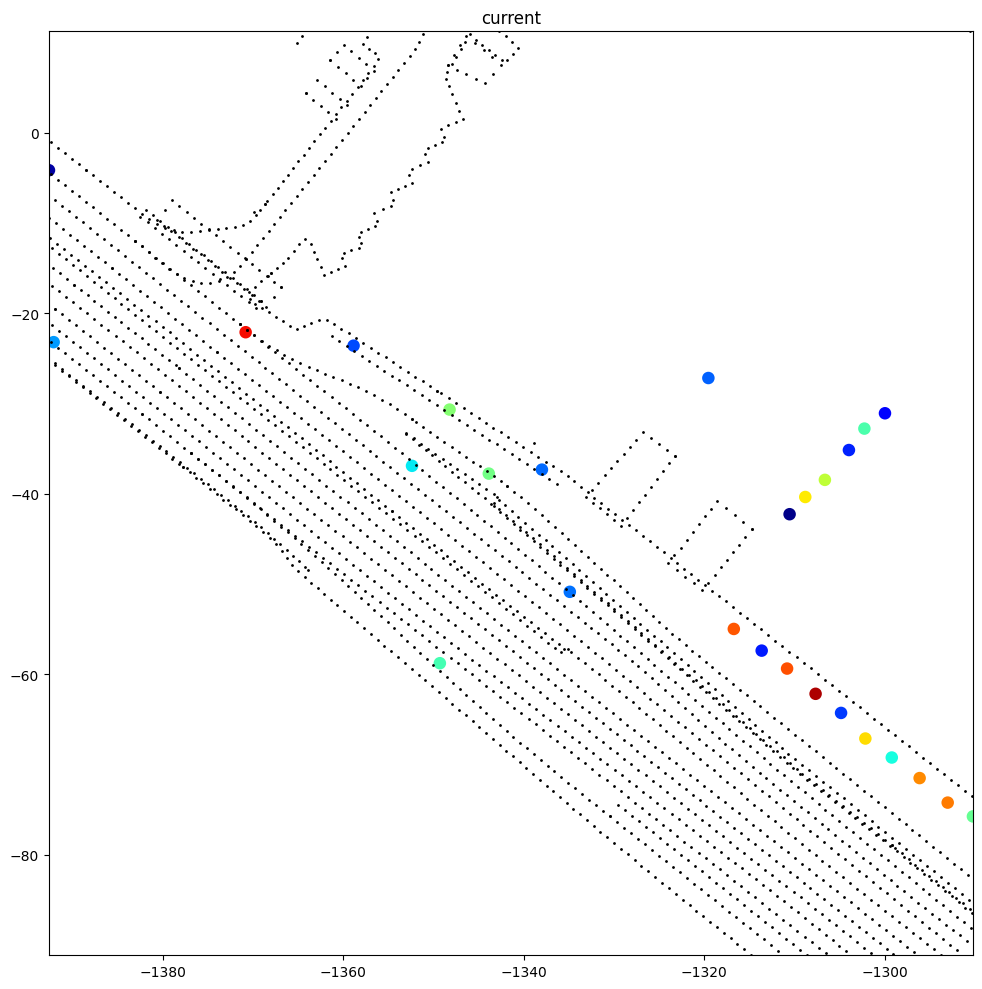

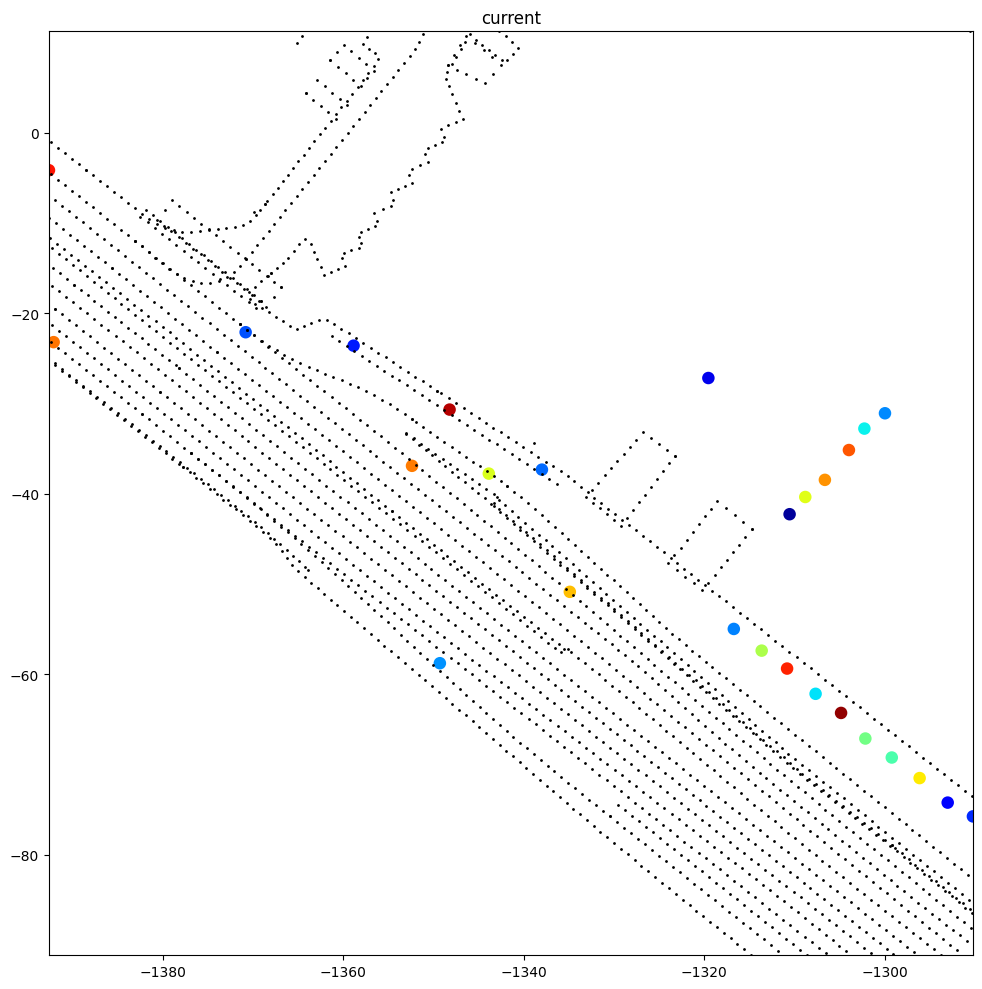

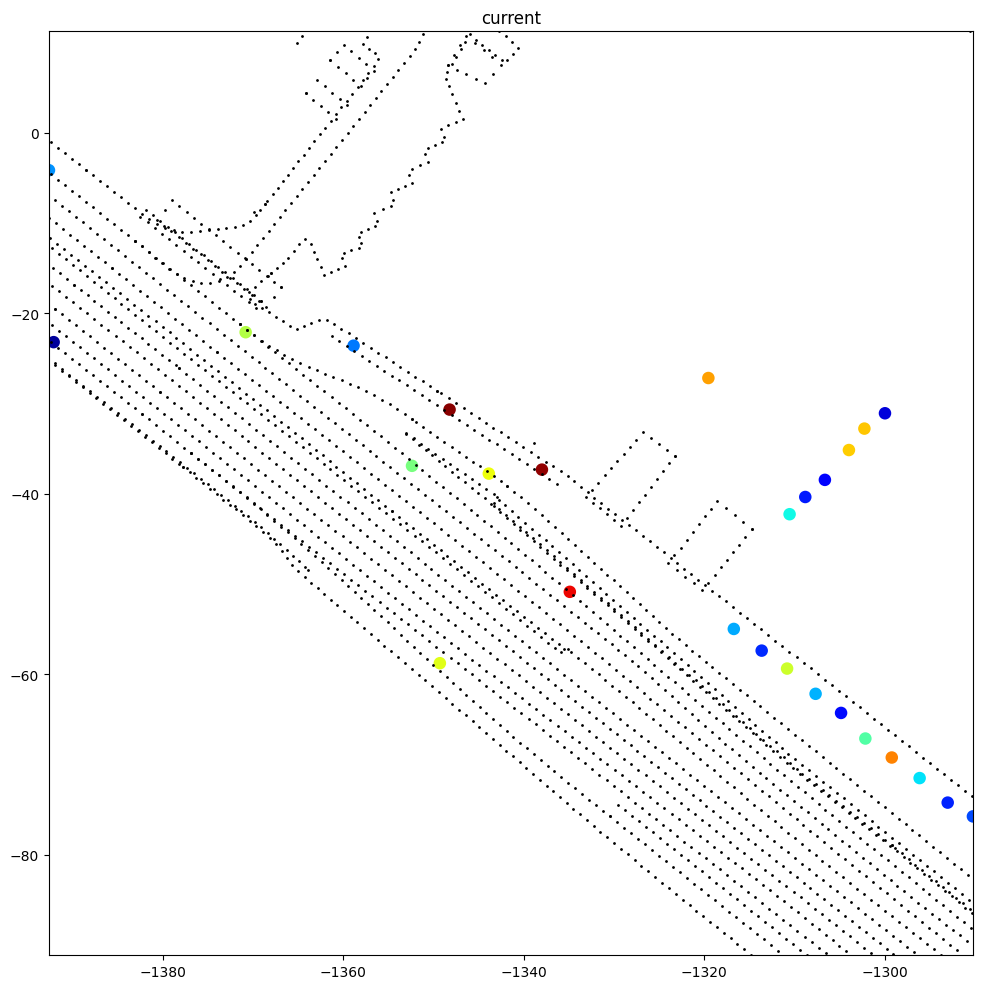

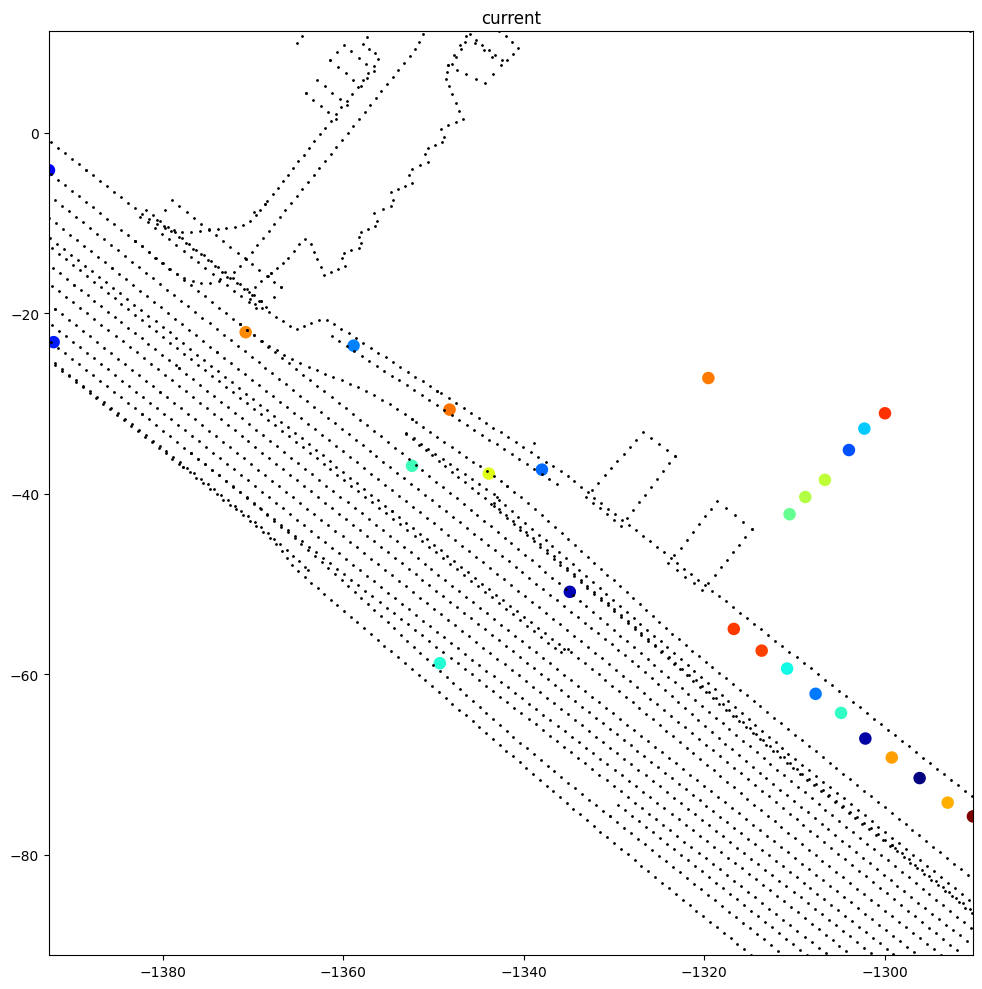

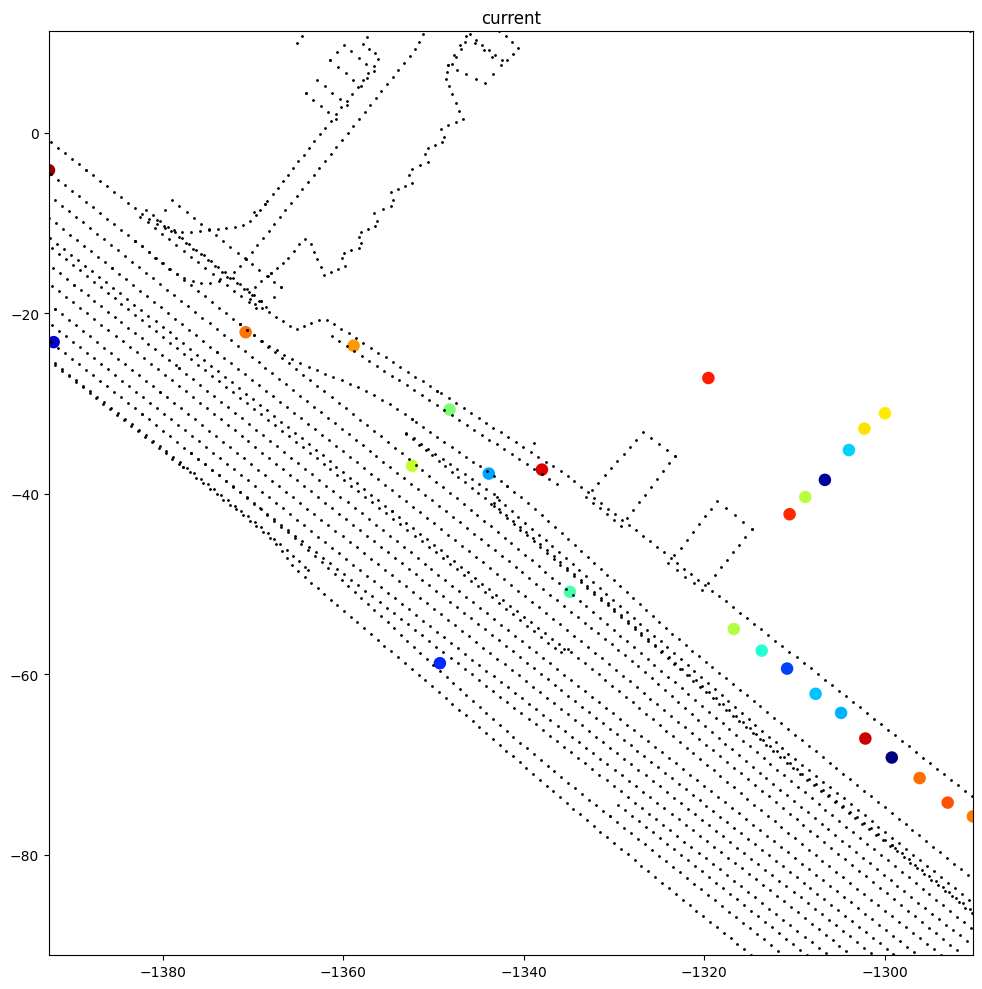

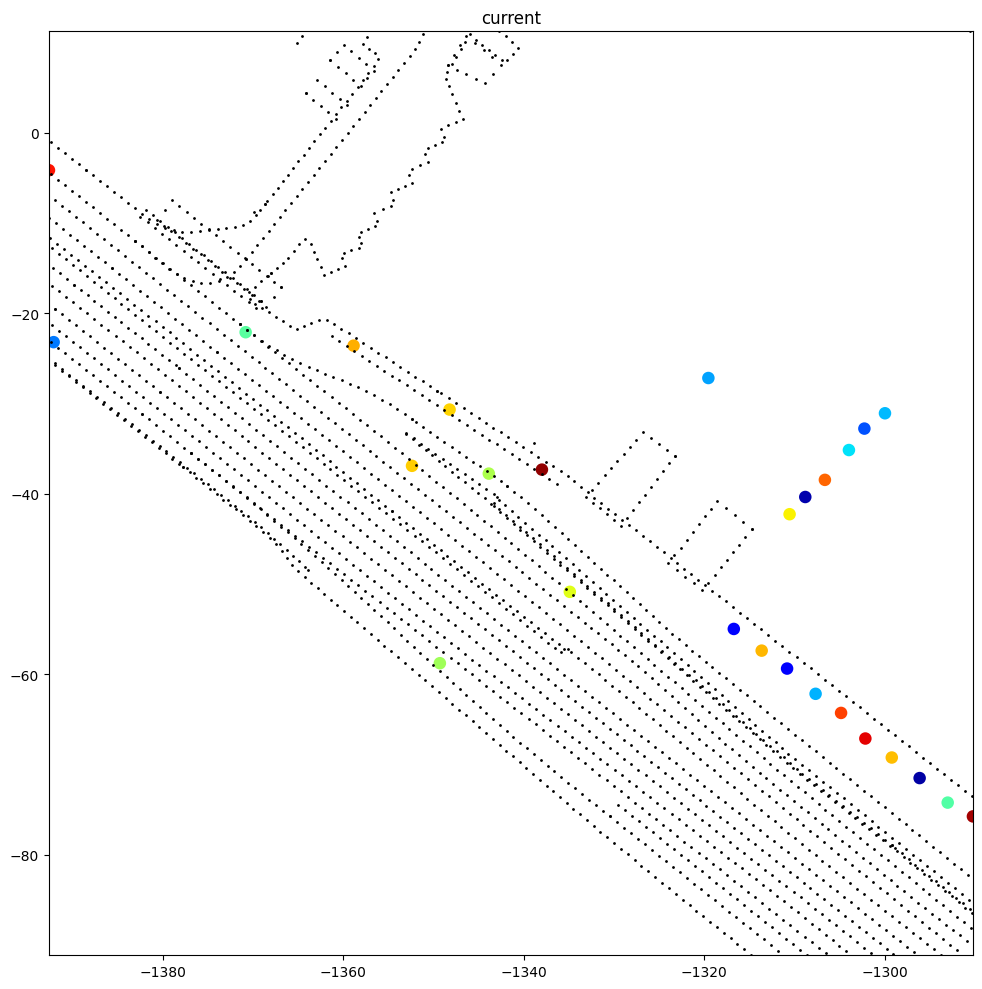

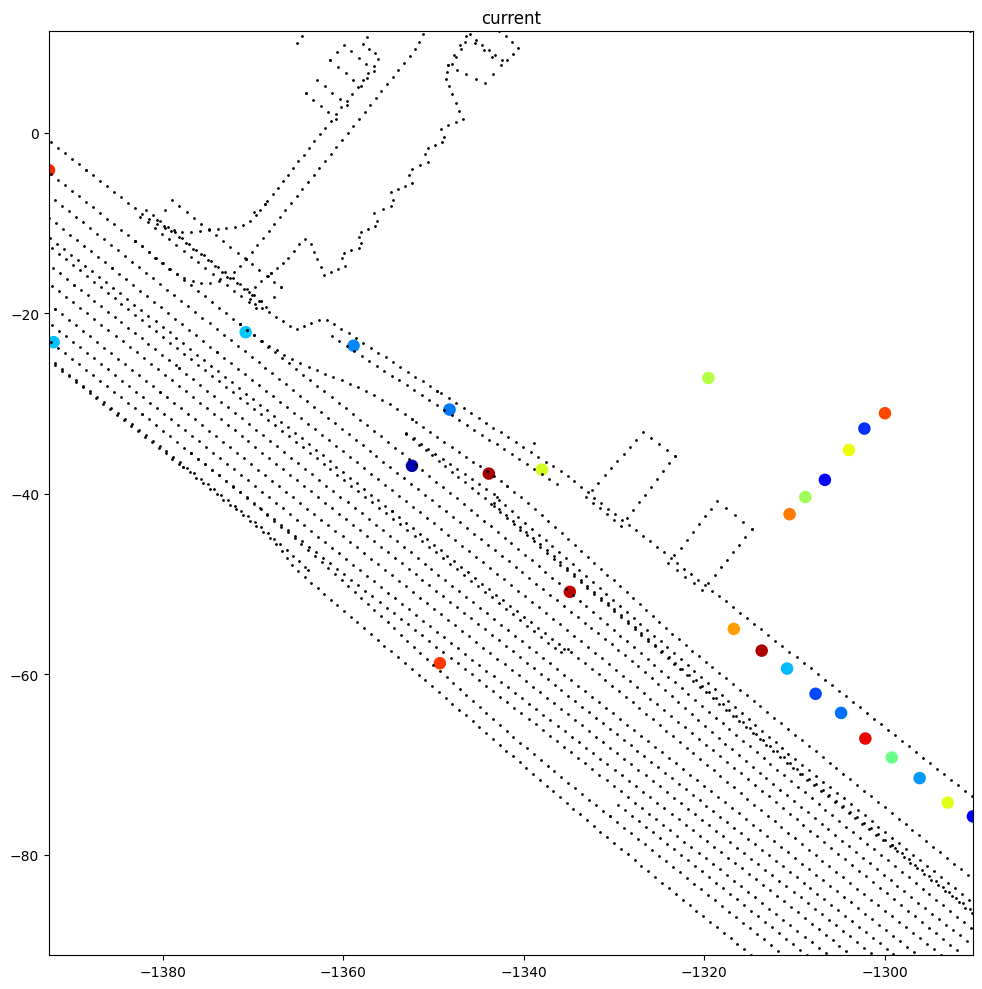

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [111]:
# I need to show only present
def showCurrent():
  current_state=tf.stack([parsed['state/current/x'], parsed['state/current/y']], -1).numpy()
  current_valid = parsed['state/current/valid'].numpy() > 0.0
  road_graph = parsed['roadgraph_samples/xyz'].numpy()
  center_y, center_x, width = get_viewport(current_state, current_valid)
  color_map = get_colormap(128)
  visualize_one_step(current_state[:,0], current_valid[:,0], road_graph,
                     'current', center_y, center_x, width, color_map, 1000)

showCurrent()